In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow-addons


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\LENOVO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Addons version:", tfa.__version__)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
# import matplotlib.pyplot as plt
# import numpy as np


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version: 2.18.0


NameError: name 'tfa' is not defined

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
Faces_FILENAMES = tf.io.gfile.glob(str('comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics/*.jpg'))
print('Faces Files:', len(Faces_FILENAMES))

Anime_FILENAMES = tf.io.gfile.glob(str('comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces/*.jpg'))
print('Anime  Files:', len(Anime_FILENAMES))

Faces Files: 10000
Anime  Files: 10000


In [6]:
REAL_FACES_FILENAMES = tf.io.gfile.glob(str('/kaggle/input/comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/samples/*.jpg'))
print('Faces  Files:', len(REAL_FACES_FILENAMES))

Faces  Files: 3


In [7]:
import random
EXTRA_Anime = random.sample(Anime_FILENAMES,len(REAL_FACES_FILENAMES))
# Random Shuffle IF needed
import random
random.shuffle(Faces_FILENAMES)
random.shuffle(Anime_FILENAMES)

In [8]:
ALL_FACES = Faces_FILENAMES + REAL_FACES_FILENAMES
ALL_COMICS = EXTRA_Anime + Anime_FILENAMES
print(len(ALL_FACES), len(ALL_COMICS))

10003 10003


In [9]:
# import shutil
# import os
# import pathlib
# import zipfile
# from glob import glob
# import logging
import warnings
# import datetime

# import numpy as np
# import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# import matplotlib.style as style
# from PIL import Image
# import seaborn as sns

# from tqdm import tqdm
# from itertools import chain
# from collections import Counter, defaultdict


# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, BatchNormalization
# from keras.layers import Conv2D, MaxPooling2D


warnings.filterwarnings('ignore')

In [10]:
#Configuration

BATCH_SIZE = 16

BUFFER_SIZE = 100
IMG_HEIGHT, IMG_WIDTH = 128, 128
CROP_SIZE = 128
TEST_SIZE = 0.01
CHANNELS = 3
HEIGHT = 128
WIDTH = 128
LABEL_SMOOTHING = 0.1

TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 1e-4
DISCRIMINATOR_LR = 4e-4

In [11]:
from sklearn.model_selection import train_test_split
train_comics_paths, test_comics_paths, train_faces_paths, test_faces_paths = train_test_split(ALL_COMICS, ALL_FACES, test_size=TEST_SIZE, random_state=420)

In [12]:
def load(comic_path,face_path):
    comic = tf.io.read_file(comic_path)
    comic = tf.image.decode_jpeg(comic, channels=3)



    face = tf.io.read_file(face_path)
    face = tf.image.decode_jpeg(face, channels=3)


    return comic ,face

def normalize(comic, face):
    """ Normalize the images to [-1, 1]
    """
    # YOUR CODE HERE
    comic = (tf.cast(comic, tf.float32) /255.0 *2) -1
    face = (tf.cast(face, tf.float32) /255.0 *2) -1
    return comic, face

def random_crop(comic, face, height, width):
    """ Stack the two images on top of each other
        Then crop together.
    """
    stacked_image = tf.stack([comic, face], axis=0)
    cropped_image = tf.image.random_crop(stacked_image,
                                         size=[2, height, width, 3])

    return cropped_image[0], cropped_image[1]

def resize(comic, face, height, width):
    """ Resize the two image to heigh, width
    """
    comic = tf.image.resize(comic,
                           [height, width],
                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    face = tf.image.resize(face,
                               [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return comic, face

@tf.function()
def random_jitter(comic, face):
    comic, face = resize(comic, face, IMG_HEIGHT, IMG_WIDTH)
    comic, face = random_crop(comic, face, CROP_SIZE, CROP_SIZE)

    # Augmentation to random flip
    if tf.random.uniform(()) > 0.5:
        comic = tf.image.flip_left_right(comic)
        face = tf.image.flip_left_right(face)

    return comic, face

def preprocess(comic_path, face_path):
    comic, face = load(comic_path, face_path)



    return comic, face
def imgaug(comic,face):
    comic,face = random_jitter(comic,face)
    comic, face = normalize(comic, face)


    return comic, face

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_comics_paths,train_faces_paths))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
train_ds = train_ds.repeat().shuffle(buffer_size=1000,reshuffle_each_iteration=True).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_comics_paths, test_faces_paths))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.repeat().shuffle(buffer_size=50).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
# Model Building

conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True,apply_spectral=False, activation=layers.LeakyReLU(0.2), name='block_x'):
    if (apply_spectral) & (apply_instancenorm ==False):
        block = tfa.layers.SpectralNormalization(layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'encoder_{name}'))(input_layer)
    else:
        block =  layers.Conv2D(filters, size,
                     strides=strides,
                     padding='same',
                     use_bias=False,
                     kernel_initializer=conv_initializer,
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        # block = gamma_initializer=gamma_initializer)(block)


    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]

    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    # block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = layers.LeakyReLU(0.2)(block)

    block = layers.Conv2D(filters, size, strides=strides, padding='same', use_bias=False,
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
    # block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True,apply_spectral=False, name='block_x'):

    if (apply_spectral) & (apply_instancenorm ==False):
        block = tfa.layers.SpectralNormalization(layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'decoder_{name}'))(input_layer)
    else:

        block = layers.Conv2DTranspose(filters, size,
                              strides=strides,
                              padding='same',
                              use_bias=False,
                              kernel_initializer=conv_initializer,
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = layers.LeakyReLU()(block)

    return block


###PatchGAN Discriminator

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[128, 128, 3], name='input_image')

    x = inp
    enc_1 = encoder_block(x, 64,  4, 2, apply_instancenorm=False, activation=layers.LeakyReLU(0.2), name='block_1')
    enc_2 = encoder_block(enc_1, 128, 4, 2, apply_instancenorm=True,apply_spectral=False, activation=layers.LeakyReLU(0.2), name='block_2')
    enc_3 = encoder_block(enc_2, 256, 4, 2, apply_instancenorm=True,apply_spectral=False, activation=layers.LeakyReLU(0.2), name='block_3')

    zero_pad1 = layers.ZeroPadding2D()(enc_3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU(0.2)(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)
tf.keras.utils.plot_model(Discriminator(), show_shapes=True, dpi=64)

def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = layers.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=layers.LeakyReLU(0.2), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True,apply_spectral=False, activation=layers.LeakyReLU(0.2), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True,apply_spectral=False, activation=layers.LeakyReLU(0.2), name='block_3')   # (bs, 64, 64, 256)

    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = layers.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection

    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True,apply_spectral=False, name='block_1') # (bs, 128, 128, 128)
    x_skip = layers.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection

    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True,apply_spectral=False, name='block_2') # (bs, 256, 256, 64)
    x_skip = layers.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = layers.Conv2D(OUTPUT_CHANNELS, 7,
                              strides=1, padding='same',
                              kernel_initializer=conv_initializer,
                              use_bias=False,
                              activation='tanh',
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = keras.Model(inputs, outputs)

    return generator

sample_generator = generator_fn()

tf.keras.utils.plot_model(sample_generator, show_shapes=True, dpi=64)



with strategy.scope():
    comics_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS)
    faces_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS)

    comics_discriminator = Discriminator() # differentiates real Comics and generated Comic
    faces_discriminator = Discriminator() # differentiates real photos and generated photos

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        comics_generator,
        faces_generator,
        comics_discriminator,
        faces_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = comics_generator
        self.p_gen = faces_generator
        self.m_disc = comics_discriminator
        self.p_disc = faces_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_comic, real_face = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Face to Comic back to Face
            fake_comic = self.m_gen(real_face, training=True)
            cycled_face = self.p_gen(fake_comic, training=True)

            # Comic to Face back to Comic
            fake_face = self.p_gen(real_comic, training=True)
            cycled_comic = self.m_gen(fake_face, training=True)

            # generating itself
            same_comic = self.m_gen(real_comic, training=True)
            same_face = self.p_gen(real_face, training=True)

            # discriminator used to check, inputing real images
            disc_real_comic = self.m_disc(real_comic, training=True)
            disc_real_face = self.p_disc(real_face, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_comic = self.m_disc(fake_comic, training=True)
            disc_fake_face = self.p_disc(fake_face, training=True)

            # evaluates generator loss
            comic_gen_loss = self.gen_loss_fn(disc_fake_comic)
            face_gen_loss = self.gen_loss_fn(disc_fake_face)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_comic, cycled_comic, self.lambda_cycle) + self.cycle_loss_fn(real_face, cycled_face, self.lambda_cycle)

            # evaluates total generator loss
            total_comic_gen_loss = comic_gen_loss + total_cycle_loss + self.identity_loss_fn(real_comic, same_comic, self.lambda_cycle)
            total_face_gen_loss = face_gen_loss + total_cycle_loss + self.identity_loss_fn(real_face, same_face, self.lambda_cycle)

            # evaluates discriminator loss
            comic_disc_loss = self.disc_loss_fn(disc_real_comic, disc_fake_comic)
            face_disc_loss = self.disc_loss_fn(disc_real_face, disc_fake_face)

        # Calculate the gradients for generator and discriminator
        comic_generator_gradients = tape.gradient(total_comic_gen_loss,
                                                  self.m_gen.trainable_variables)
        face_generator_gradients = tape.gradient(total_face_gen_loss,
                                                  self.p_gen.trainable_variables)

        comic_discriminator_gradients = tape.gradient(comic_disc_loss,
                                                      self.m_disc.trainable_variables)
        face_discriminator_gradients = tape.gradient(face_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(comic_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(face_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(comic_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(face_discriminator_gradients,
                                                  self.p_disc.trainable_variables))

        return {
            "face_gen_loss": total_comic_gen_loss,
            "anime_gen_loss": total_face_gen_loss,
            "face_disc_loss": comic_disc_loss,
            "anime_disc_loss": face_disc_loss
        }


## Loss Def

####Discriminator Loss with label smoothing

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

####Generator Loss

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

####Cycle Loss

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

#### Identity Loss

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Optimizer

with strategy.scope():
    comic_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)
    face_generator_optimizer = tf.keras.optimizers.Adam(GENERATOR_LR, beta_1=0.5)

    comic_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)
    face_discriminator_optimizer = tf.keras.optimizers.Adam(DISCRIMINATOR_LR, beta_1=0.5)

In [16]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        comics_generator, faces_generator, comics_discriminator, faces_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = comic_generator_optimizer,
        p_gen_optimizer = face_generator_optimizer,
        m_disc_optimizer = comic_discriminator_optimizer,
        p_disc_optimizer = face_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )


## Aux Function

def generate_images(model, test_input,epoch,save_path = ''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(20,20))

    display_list = [test_input[0], prediction[0]]

    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    if save_path != '':
        plt.savefig(f'{save_path}/{epoch}.jpg', bbox_inches='tight')


    plt.show()

In [17]:
## Custom CalLBack

from tensorflow.keras.callbacks import Callback
class GANMonitor(Callback):
    def __init__(self, num_img=1,save_every_epoch=4,watch_every_epoch=2,save_dir='/kaggle/working/'):
        self.num_img = num_img
        self.save_every_epoch = save_every_epoch
        self.watch_every_epoch = watch_every_epoch
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Generate Image every second epoch
        if epoch % self.watch_every_epoch == 0:
            for example_input, example_target in test_ds.take(self.num_img): #Generate Comic from Photo
                generate_images(comics_generator, example_target,epoch,save_path = '')
            for example_input, example_target in test_ds.take(self.num_img): #Generate Photo from Comic
                generate_images(faces_generator, example_input,epoch,save_path='')
        if (epoch > 0) & (epoch % self.save_every_epoch == 0):
            #Save Generator
            comics_generator.save(f"{self.save_dir}/AnimeGenTrain_{epoch}.h5",save_format='h5',overwrite=True)
            faces_generator.save(f"{self.save_dir}/FaceGenTrain_{epoch}.h5",save_format='h5',overwrite=True)

In [18]:
STEP=len(train_comics_paths)//BATCH_SIZE
print(STEP)

618


Epoch 1/50


2023-11-15 10:42:52.115653: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.132928: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.149946: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.166444: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.183236: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.200014: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:42:52.217311: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  1/618 [..............................] - ETA: 17:05:10 - face_gen_loss: 13.4145 - anime_gen_loss: 13.4751 - face_disc_loss: 0.6930 - anime_disc_loss: 0.6931

2023-11-15 10:44:31.735629: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.736183: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.736300: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.736392: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.736518: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.739582: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-15 10:44:31.739663: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

618/618 [==============================] - ETA: 0s - face_gen_loss: 4.9817 - anime_gen_loss: 5.5532 - face_disc_loss: 0.4509 - anime_disc_loss: 0.3392

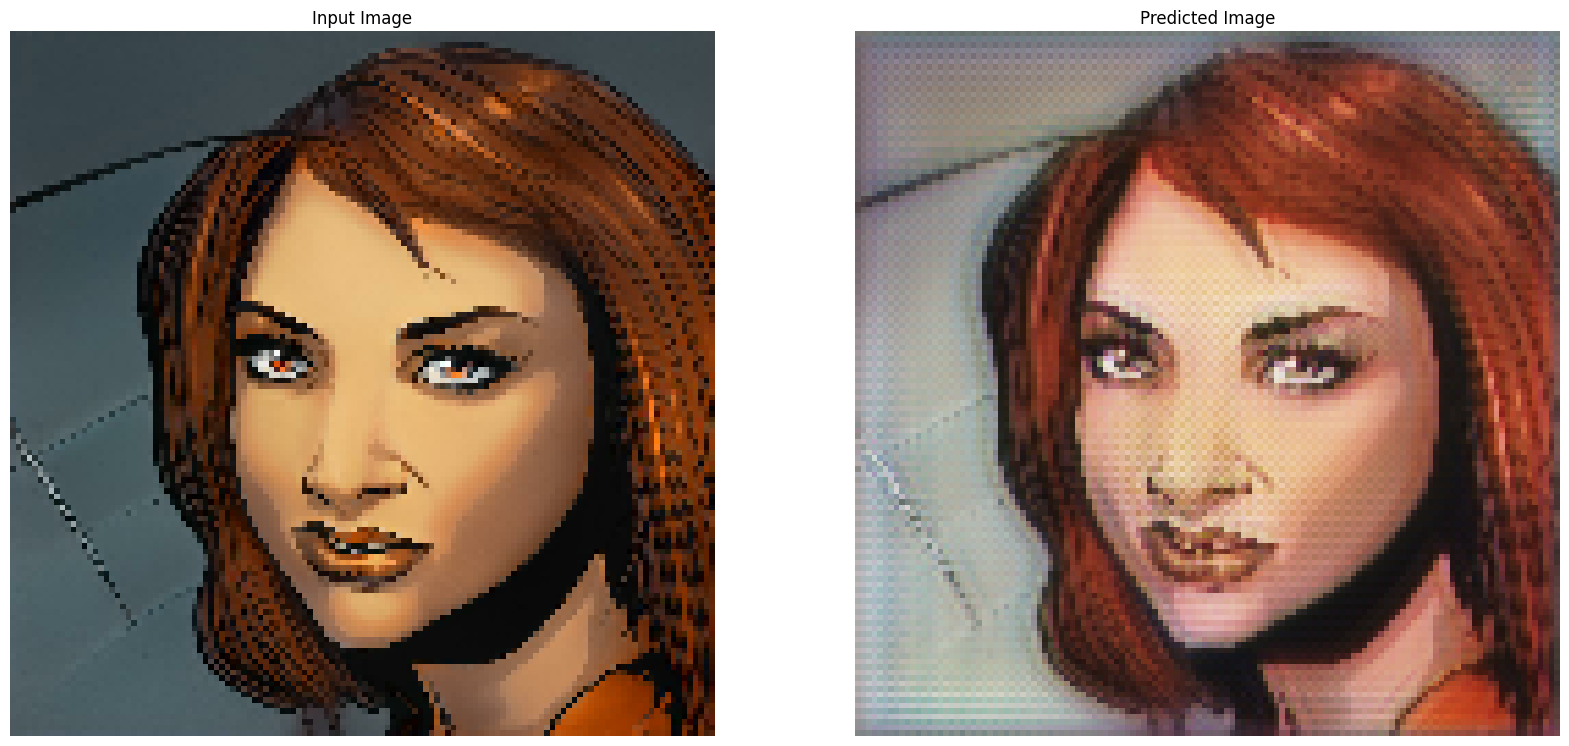

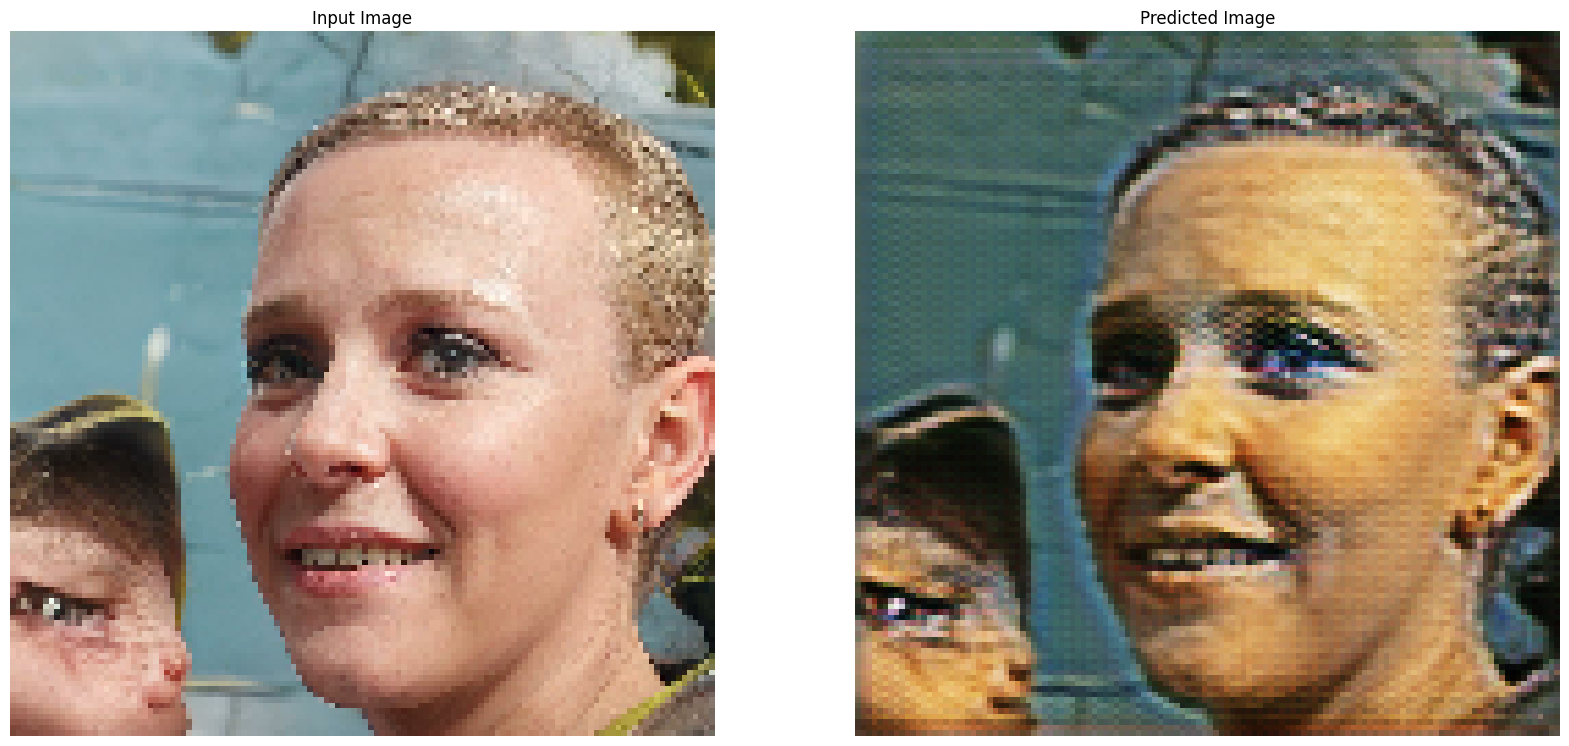

618/618 [==============================] - 162s 101ms/step - face_gen_loss: 4.9810 - anime_gen_loss: 5.5526 - face_disc_loss: 0.4508 - anime_disc_loss: 0.3391
Epoch 2/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.7474 - anime_gen_loss: 5.0962 - face_disc_loss: 0.4099 - anime_disc_loss: 0.3205
Epoch 3/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.8628 - anime_gen_loss: 4.7921 - face_disc_loss: 0.4255 - anime_disc_loss: 0.3789
Epoch 4/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.9609 - anime_gen_loss: 4.5856 - face_disc_loss: 0.4090 - anime_disc_loss: 0.4081
Epoch 5/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 4.8300 - anime_gen_loss: 4.4808 - face_disc_loss: 0.4341 - anime_disc_loss: 0.4365

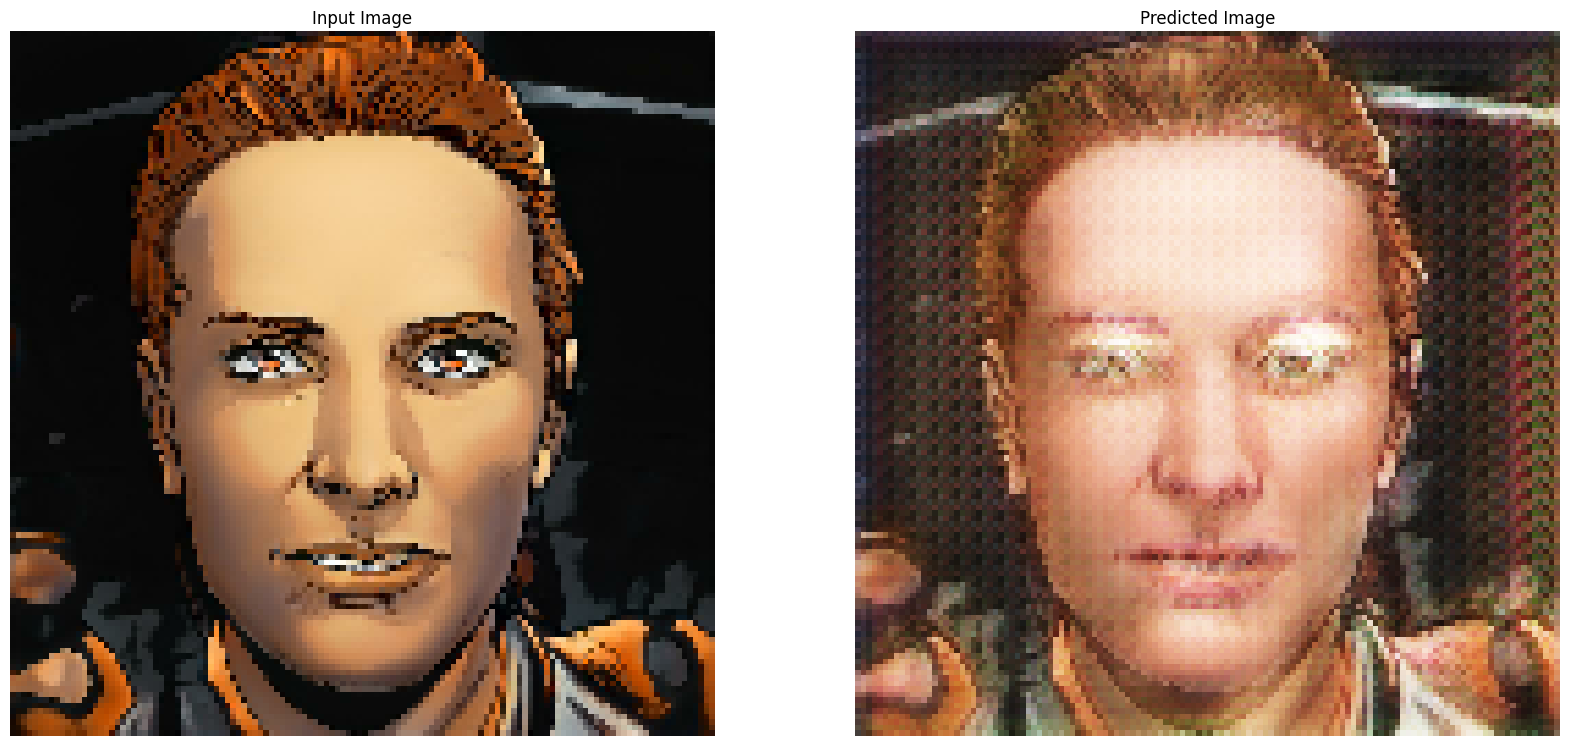

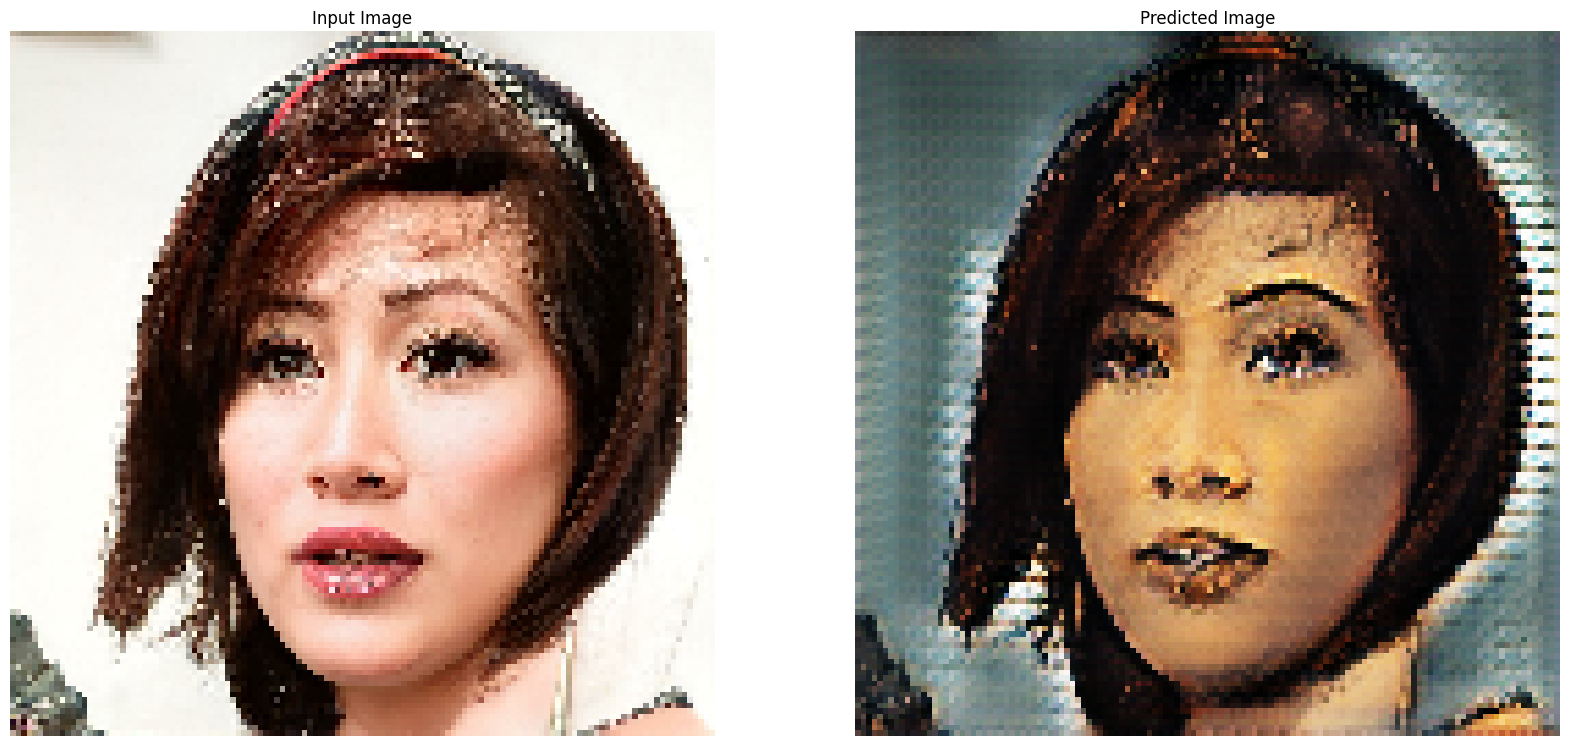

618/618 [==============================] - 61s 98ms/step - face_gen_loss: 4.8306 - anime_gen_loss: 4.4812 - face_disc_loss: 0.4341 - anime_disc_loss: 0.4364
Epoch 6/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 4.6398 - anime_gen_loss: 4.3112 - face_disc_loss: 0.4379 - anime_disc_loss: 0.4343WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.6395 - anime_gen_loss: 4.3106 - face_disc_loss: 0.4378 - anime_disc_loss: 0.4342
Epoch 7/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 4.5082 - anime_gen_loss: 4.2002 - face_disc_loss: 0.4637 - anime_disc_loss: 0.4557
Epoch 8/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.3105 - anime_gen_loss: 4.0341 - face_disc_loss: 0.4807 - anime_disc_loss: 0.4847
Epoch 9/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 4.1515 - anime_gen_loss: 3.9500 - face_disc_loss: 0.4991 - anime_disc_loss: 0.4860

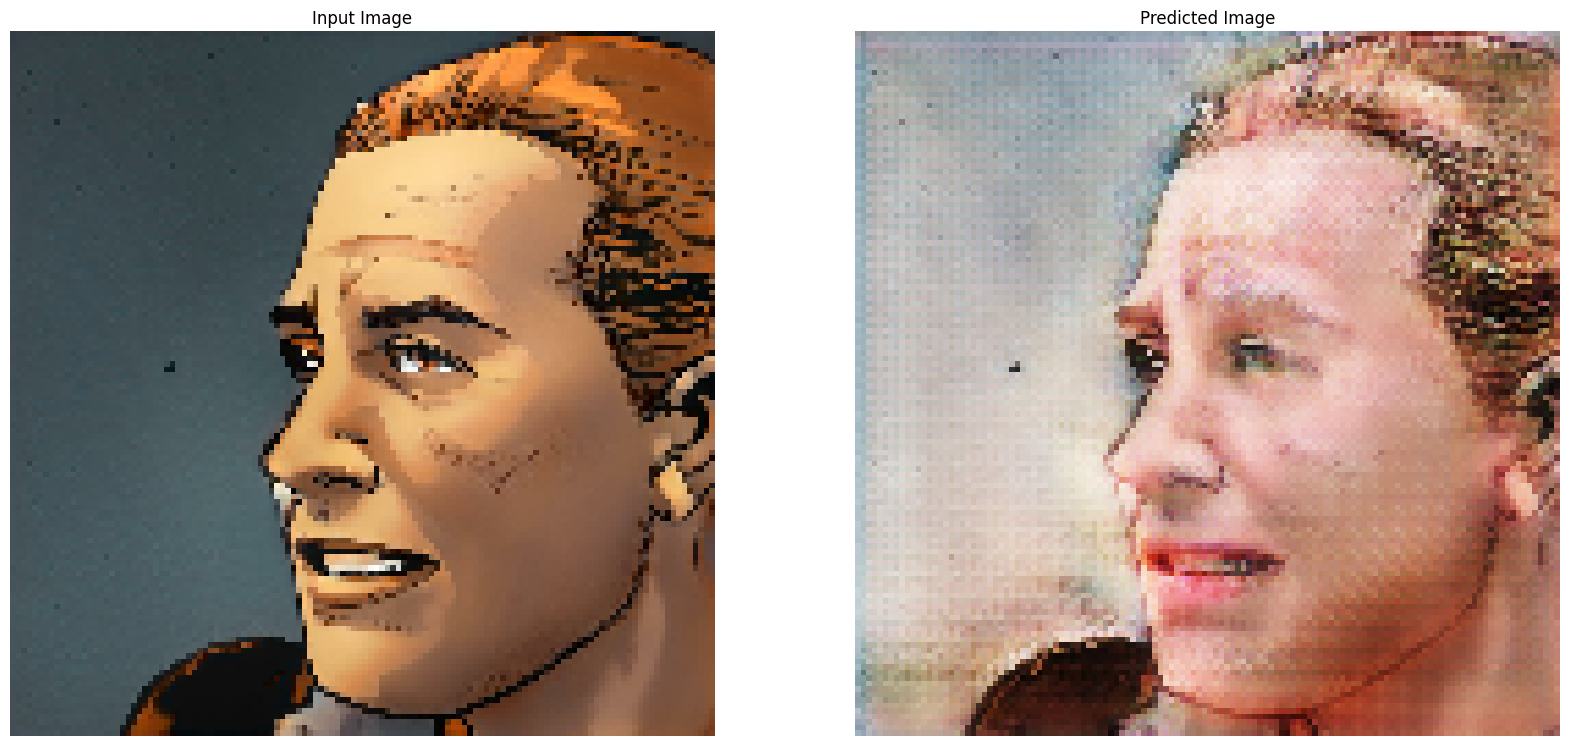

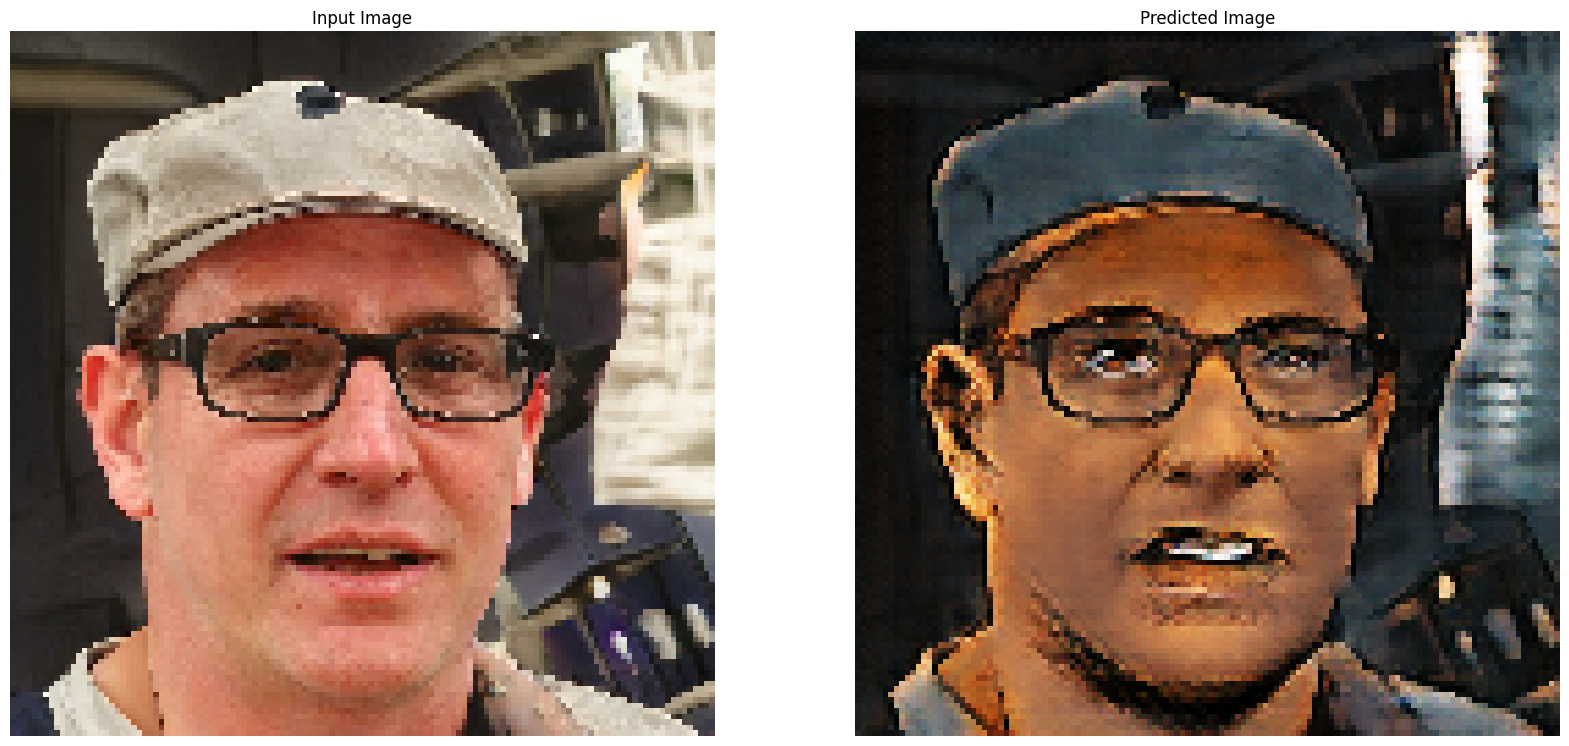

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 4.1514 - anime_gen_loss: 3.9497 - face_disc_loss: 0.4992 - anime_disc_loss: 0.4858
Epoch 10/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 4.0802 - anime_gen_loss: 3.9345 - face_disc_loss: 0.5061 - anime_disc_loss: 0.4863
Epoch 11/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.9862 - anime_gen_loss: 3.8539 - face_disc_loss: 0.5072 - anime_disc_loss: 0.4871WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.9849 - anime_gen_loss: 3.8520 - face_disc_loss: 0.5072 - anime_disc_loss: 0.4877
Epoch 12/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.9039 - anime_gen_loss: 3.8917 - face_disc_loss: 0.5145 - anime_disc_loss: 0.4632
Epoch 13/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.8619 - anime_gen_loss: 3.9015 - face_disc_loss: 0.5139 - anime_disc_loss: 0.4778

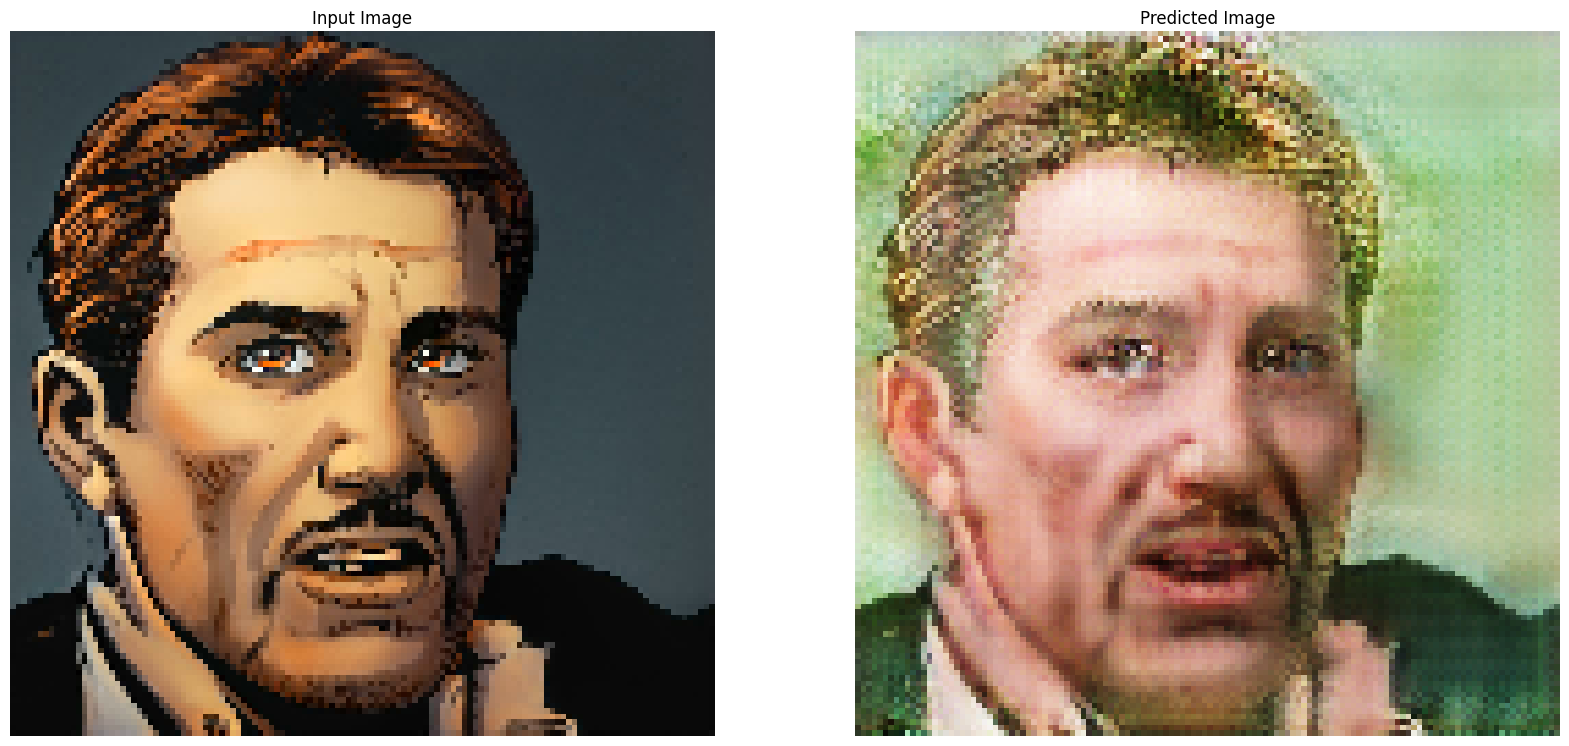

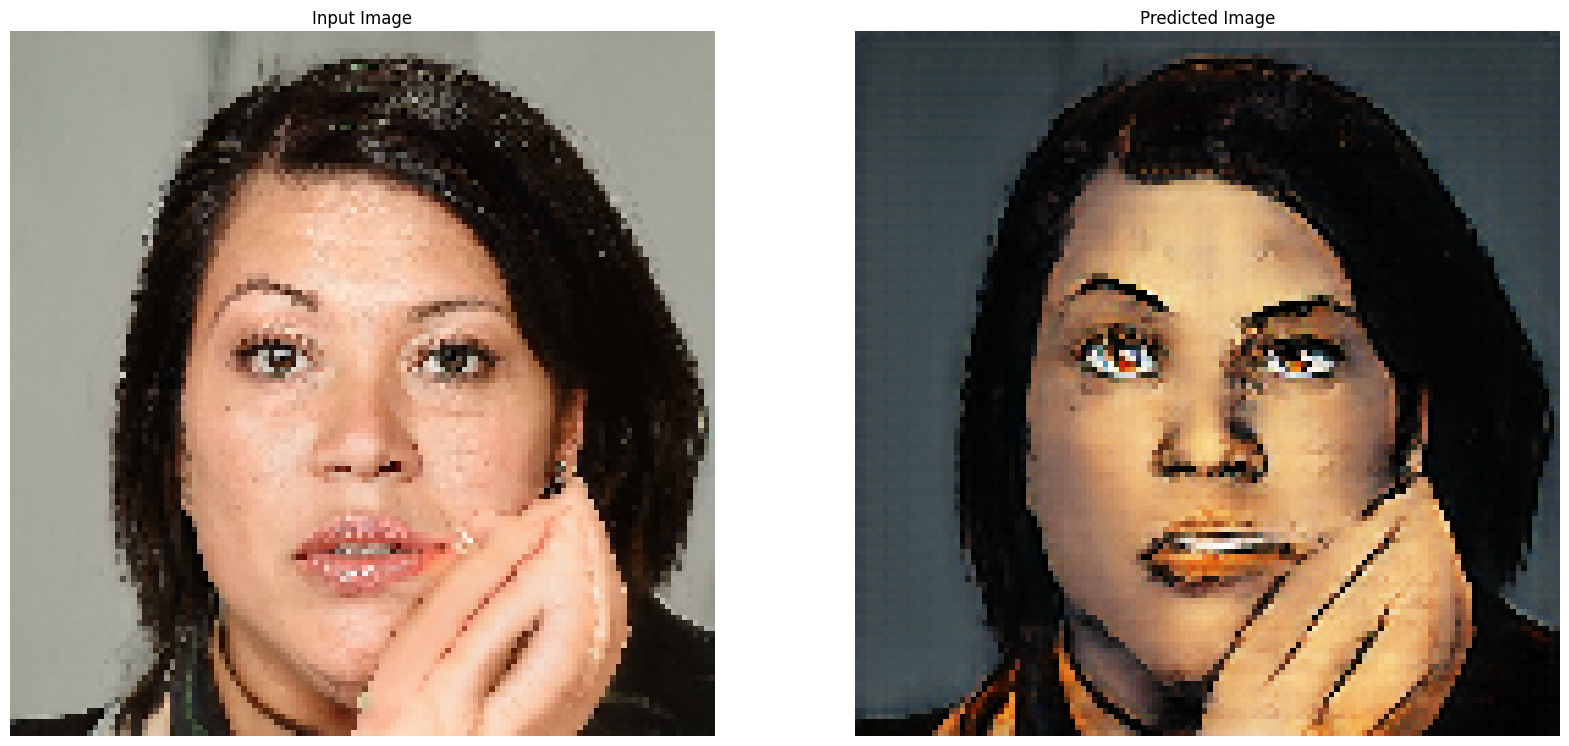

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.8627 - anime_gen_loss: 3.9008 - face_disc_loss: 0.5137 - anime_disc_loss: 0.4779
Epoch 14/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.8348 - anime_gen_loss: 3.9378 - face_disc_loss: 0.5240 - anime_disc_loss: 0.4721
Epoch 15/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.7428 - anime_gen_loss: 3.9117 - face_disc_loss: 0.5288 - anime_disc_loss: 0.4742
Epoch 16/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.7021 - anime_gen_loss: 3.8486 - face_disc_loss: 0.5312 - anime_disc_loss: 0.4462WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.7022 - anime_gen_loss: 3.8475 - face_disc_loss: 0.5312 - anime_disc_loss: 0.4463
Epoch 17/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.6618 - anime_gen_loss: 3.8277 - face_disc_loss: 0.5316 - anime_disc_loss: 0.4693

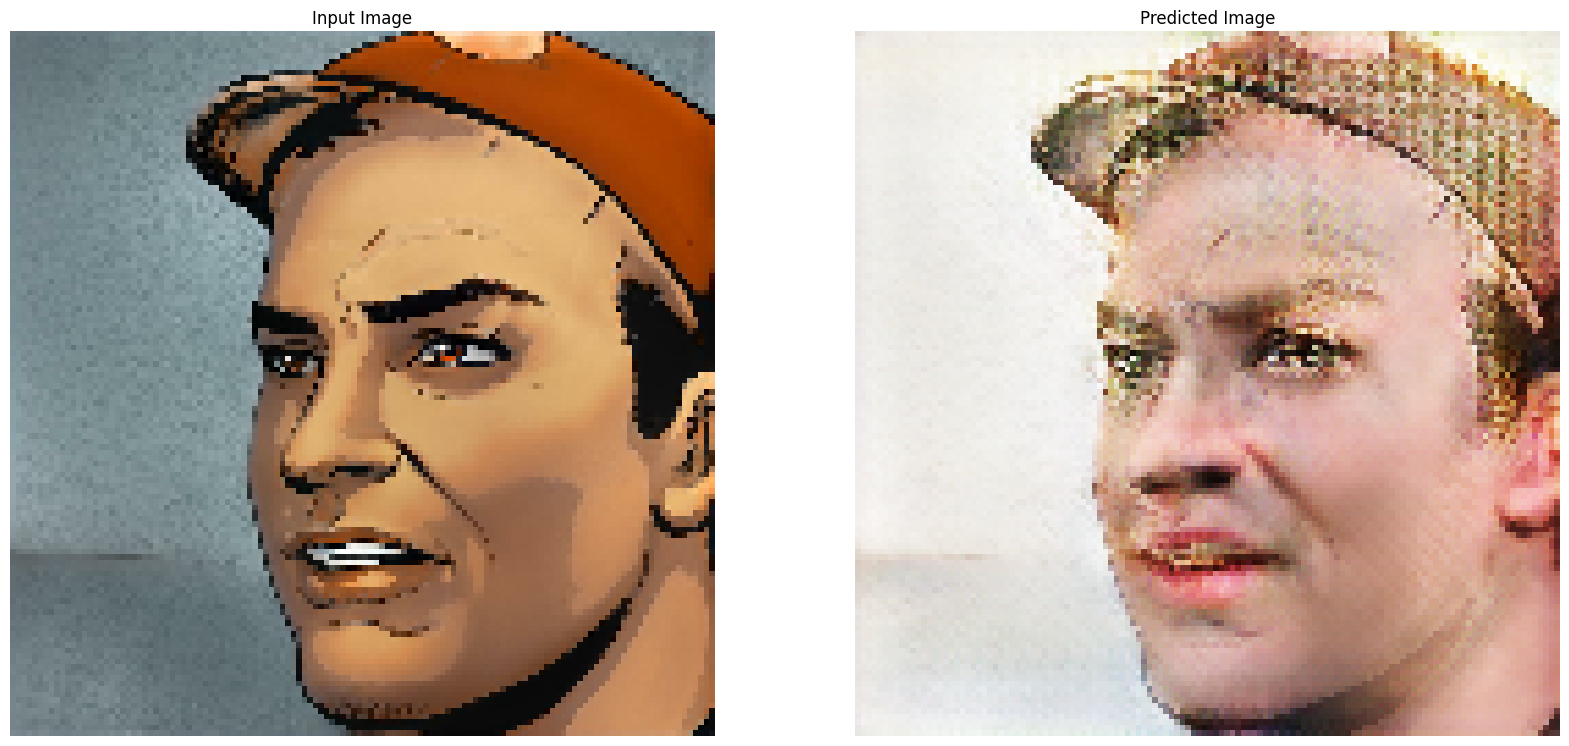

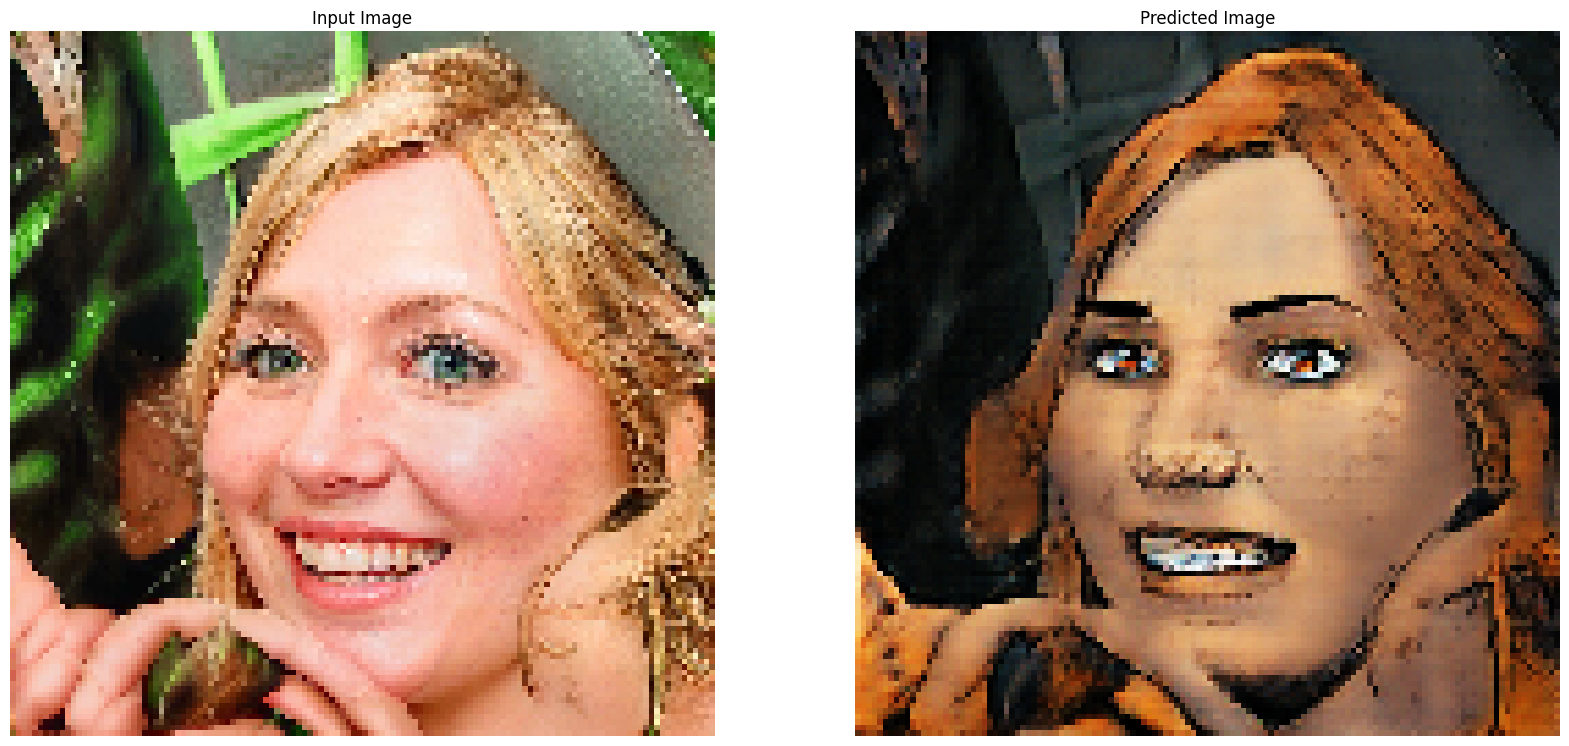

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.6611 - anime_gen_loss: 3.8260 - face_disc_loss: 0.5319 - anime_disc_loss: 0.4693
Epoch 18/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.6349 - anime_gen_loss: 3.8695 - face_disc_loss: 0.5410 - anime_disc_loss: 0.4543
Epoch 19/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.5756 - anime_gen_loss: 3.8393 - face_disc_loss: 0.5423 - anime_disc_loss: 0.4477
Epoch 20/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.5721 - anime_gen_loss: 3.7962 - face_disc_loss: 0.5461 - anime_disc_loss: 0.4707
Epoch 21/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.5105 - anime_gen_loss: 3.7736 - face_disc_loss: 0.5524 - anime_disc_loss: 0.4904

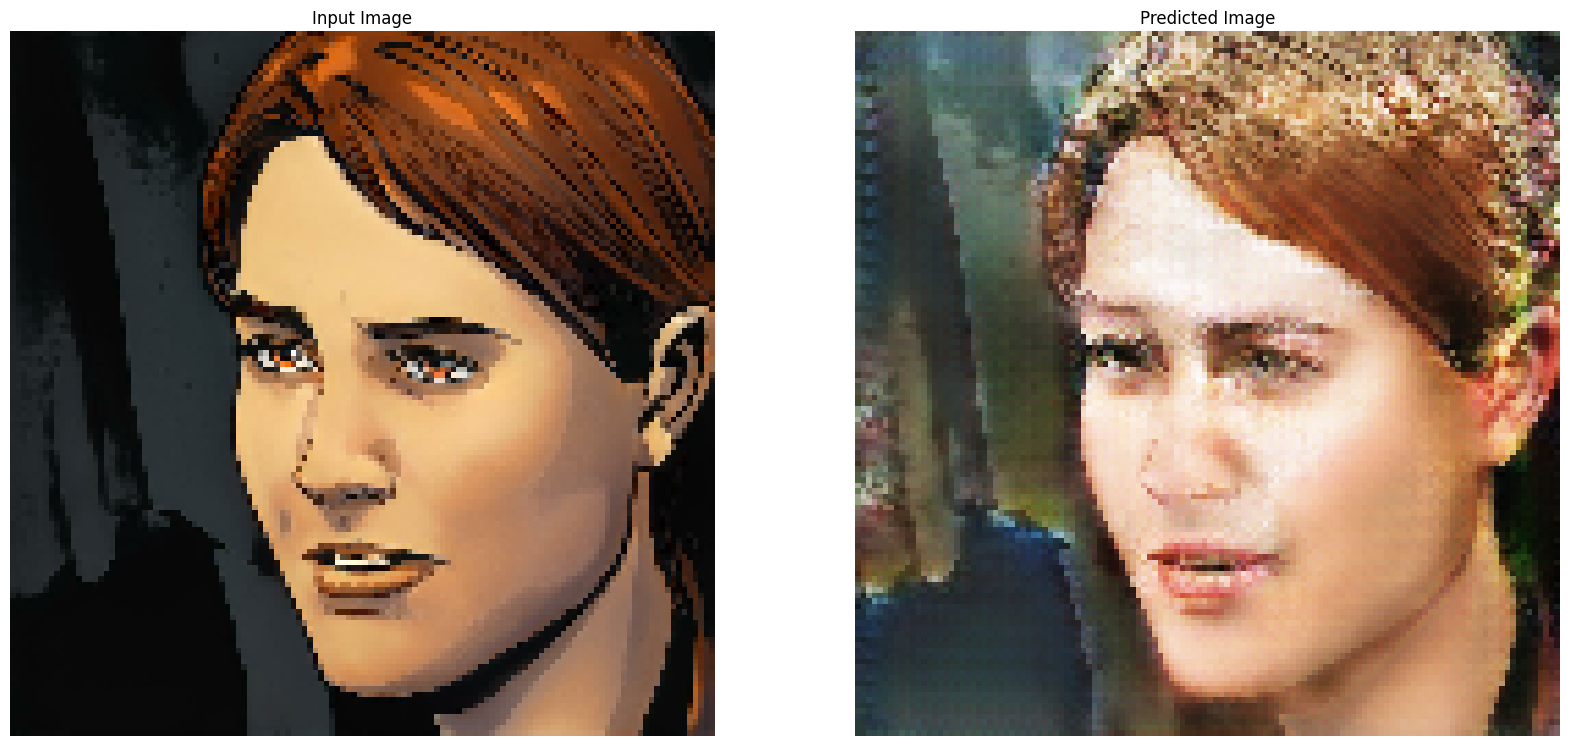

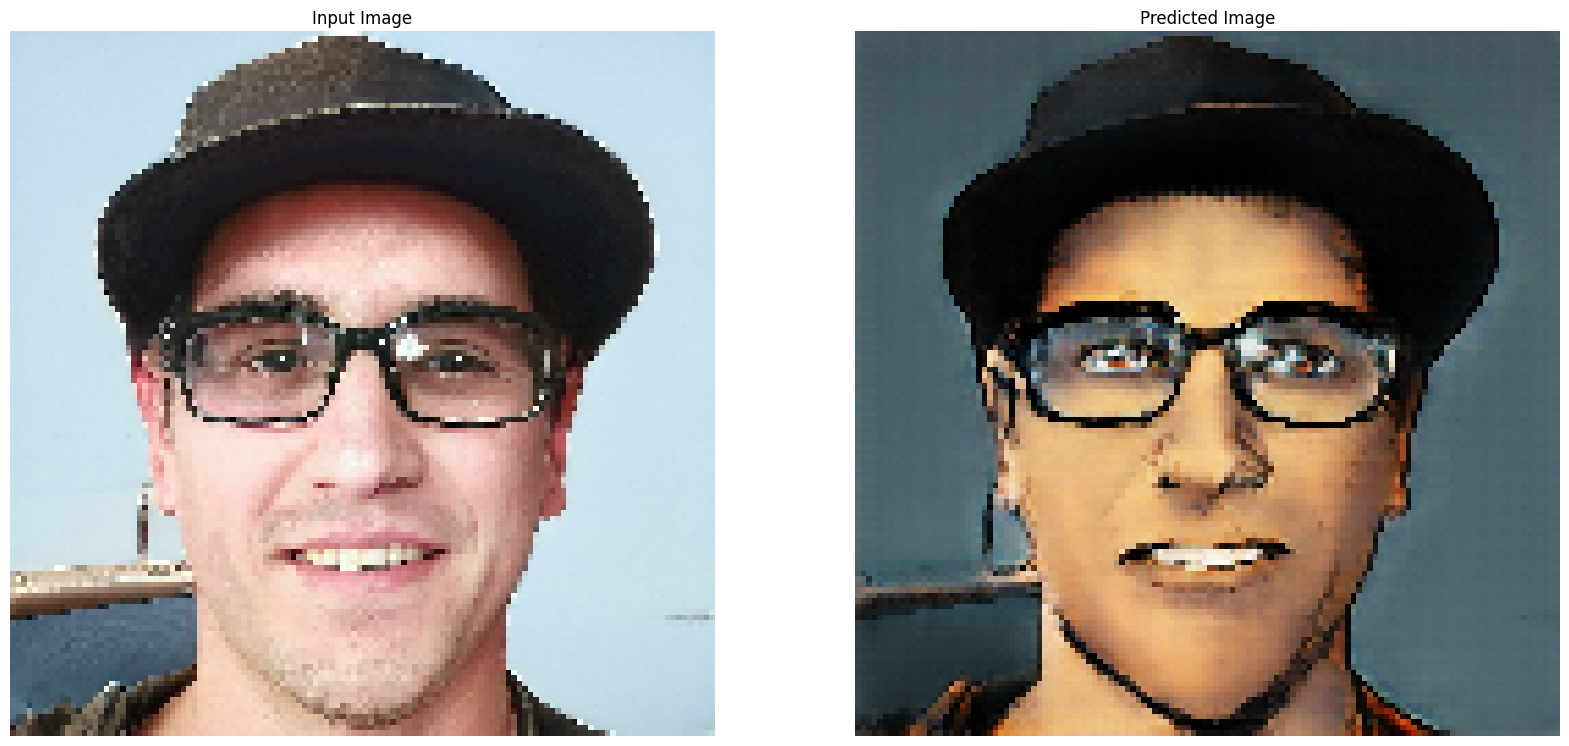

618/618 [==============================] - 61s 98ms/step - face_gen_loss: 3.5099 - anime_gen_loss: 3.7734 - face_disc_loss: 0.5522 - anime_disc_loss: 0.4903
Epoch 22/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.5303 - anime_gen_loss: 3.8034 - face_disc_loss: 0.5565 - anime_disc_loss: 0.4455
Epoch 23/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.4738 - anime_gen_loss: 3.7757 - face_disc_loss: 0.5551 - anime_disc_loss: 0.4630
Epoch 24/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.4267 - anime_gen_loss: 3.6990 - face_disc_loss: 0.5609 - anime_disc_loss: 0.4626
Epoch 25/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.4168 - anime_gen_loss: 3.6152 - face_disc_loss: 0.5565 - anime_disc_loss: 0.5198

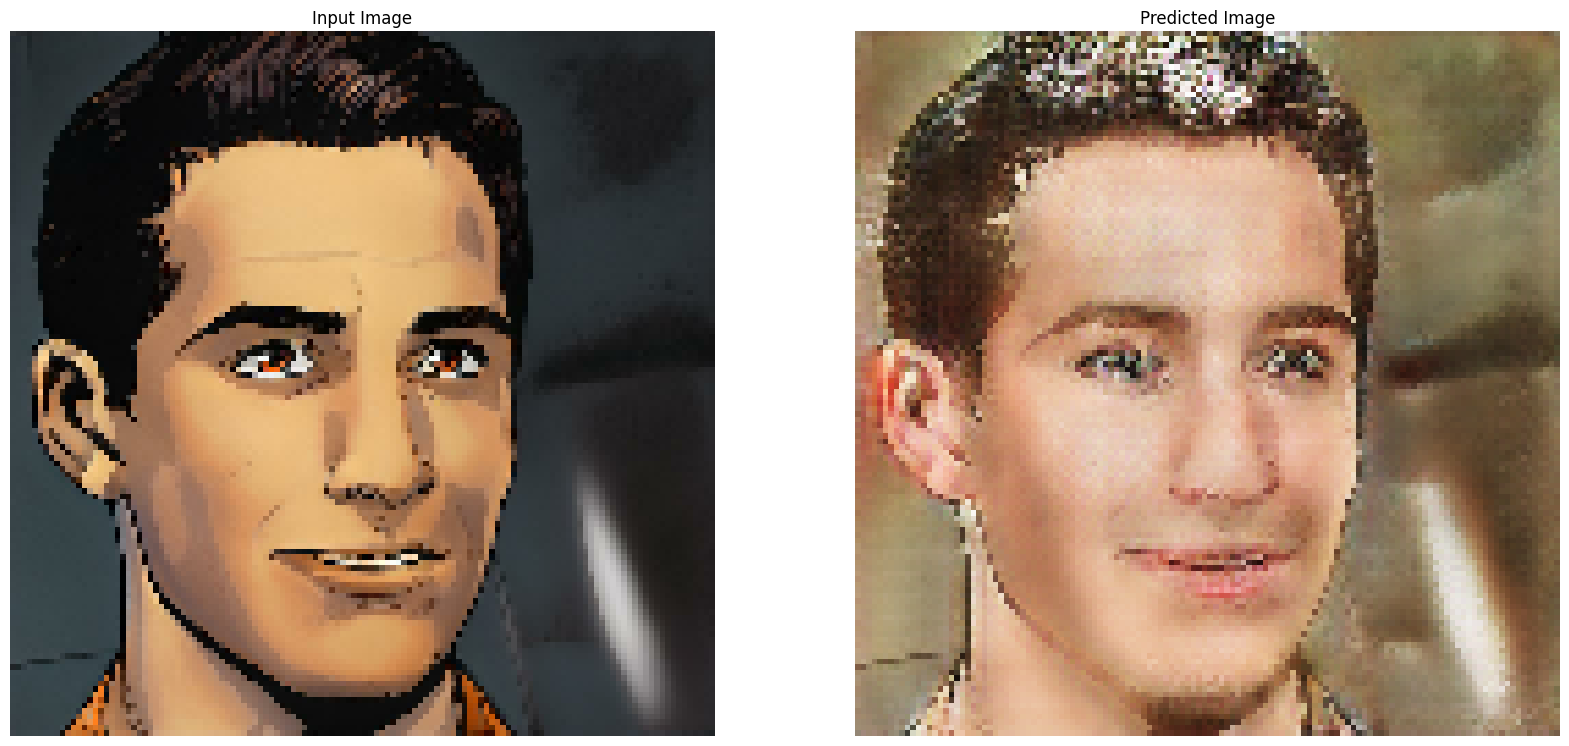

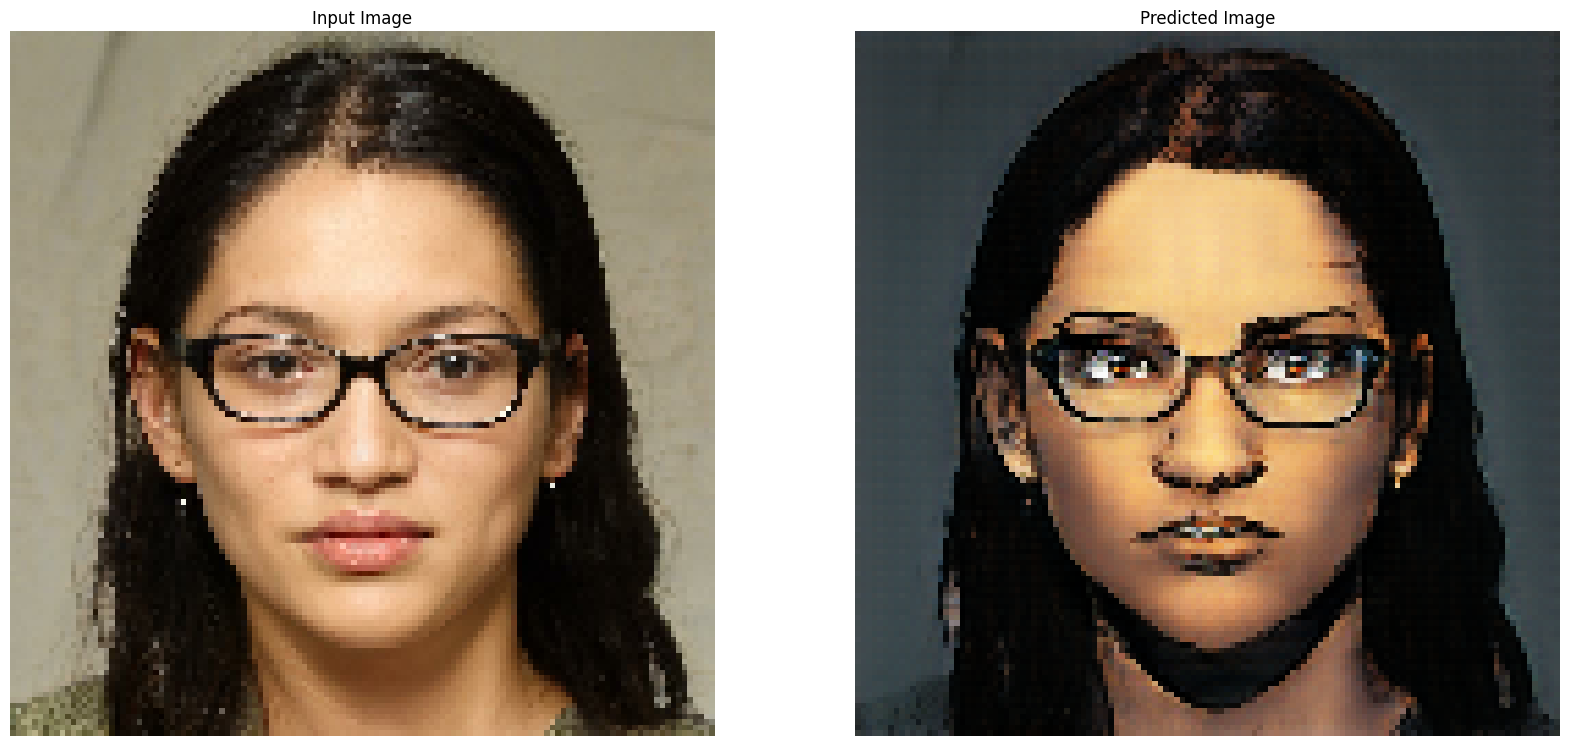

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.4153 - anime_gen_loss: 3.6140 - face_disc_loss: 0.5569 - anime_disc_loss: 0.5199
Epoch 26/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.3814 - anime_gen_loss: 3.5797 - face_disc_loss: 0.5620 - anime_disc_loss: 0.4831WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.3829 - anime_gen_loss: 3.5795 - face_disc_loss: 0.5619 - anime_disc_loss: 0.4833
Epoch 27/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.3793 - anime_gen_loss: 3.6165 - face_disc_loss: 0.5704 - anime_disc_loss: 0.4999
Epoch 28/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.3410 - anime_gen_loss: 3.5292 - face_disc_loss: 0.5715 - anime_disc_loss: 0.4914
Epoch 29/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.3204 - anime_gen_loss: 3.5351 - face_disc_loss: 0.5692 - anime_disc_loss: 0.4950

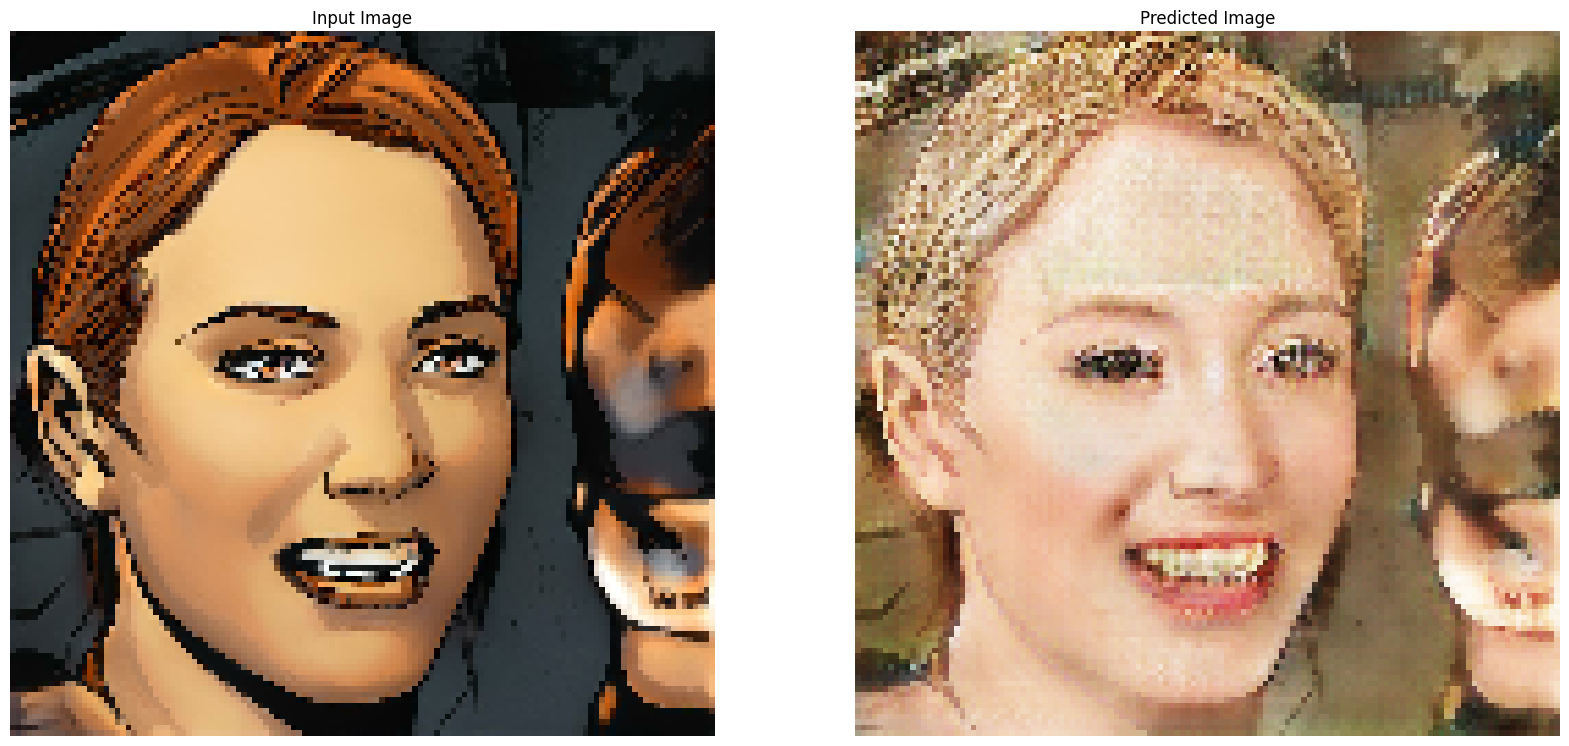

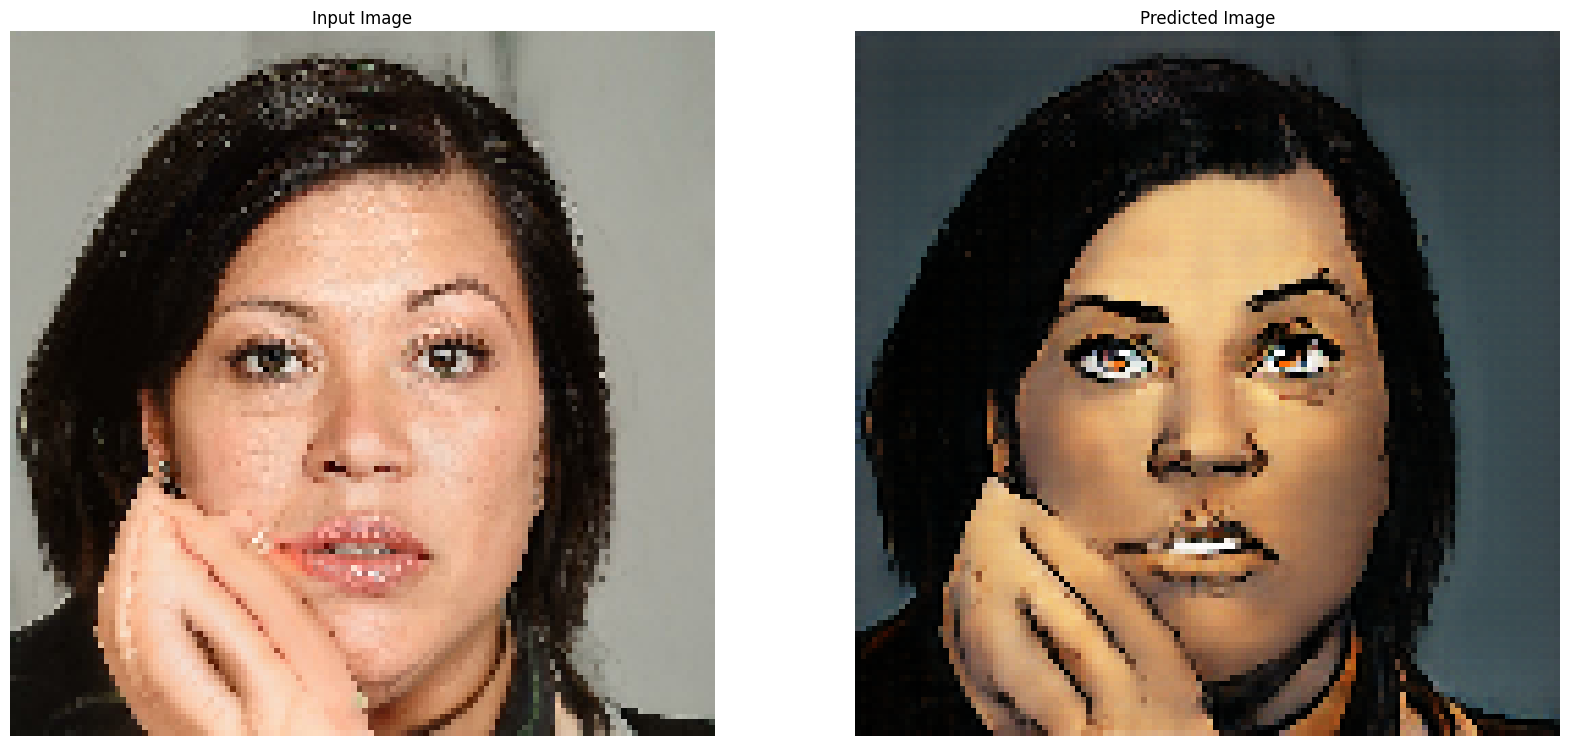

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.3205 - anime_gen_loss: 3.5348 - face_disc_loss: 0.5692 - anime_disc_loss: 0.4949
Epoch 30/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.3256 - anime_gen_loss: 3.5547 - face_disc_loss: 0.5752 - anime_disc_loss: 0.5178
Epoch 31/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.3155 - anime_gen_loss: 3.5378 - face_disc_loss: 0.5723 - anime_disc_loss: 0.4869WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.3154 - anime_gen_loss: 3.5367 - face_disc_loss: 0.5726 - anime_disc_loss: 0.4868
Epoch 32/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.2591 - anime_gen_loss: 3.5253 - face_disc_loss: 0.5795 - anime_disc_loss: 0.5330
Epoch 33/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.2690 - anime_gen_loss: 3.4661 - face_disc_loss: 0.5773 - anime_disc_loss: 0.4896

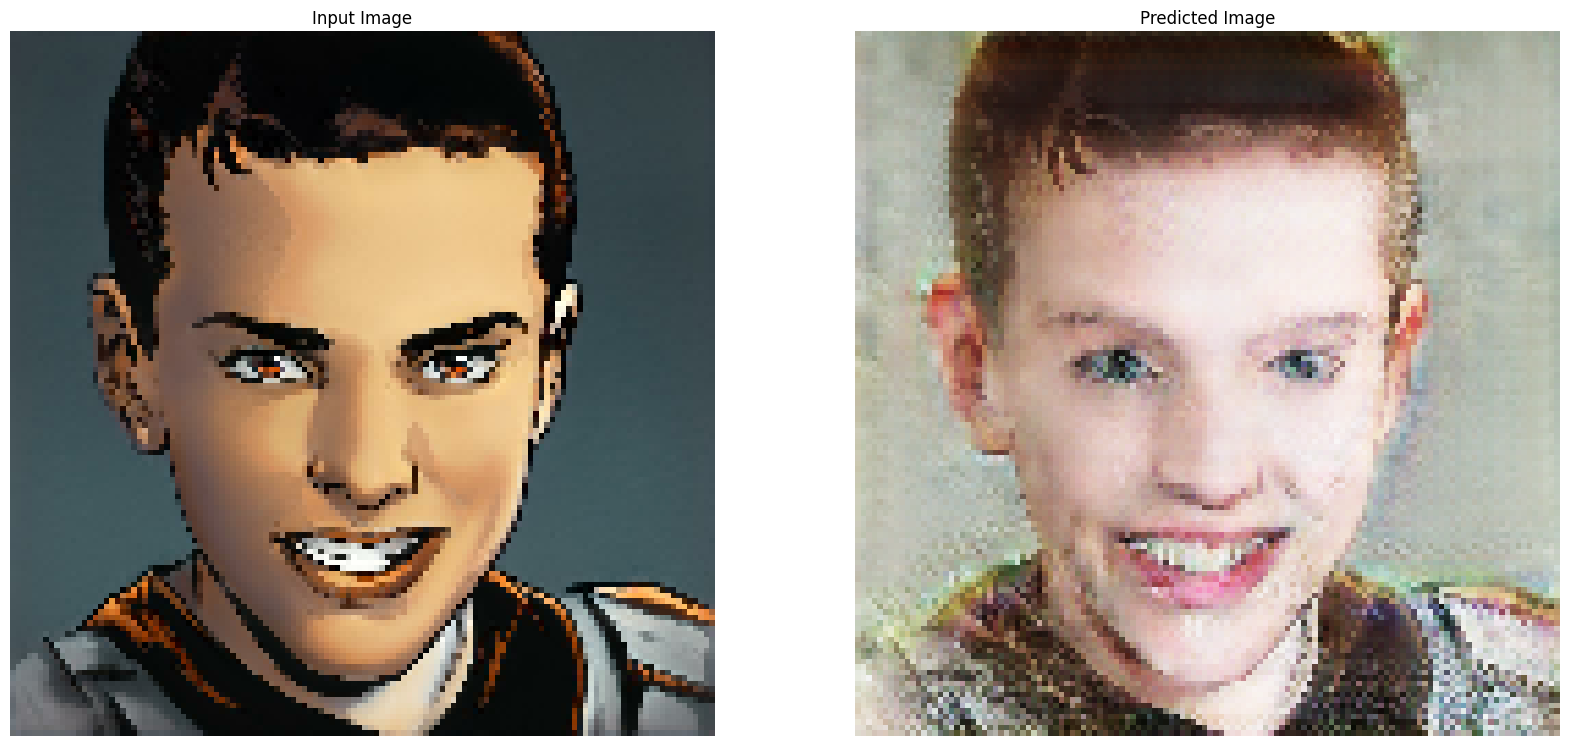

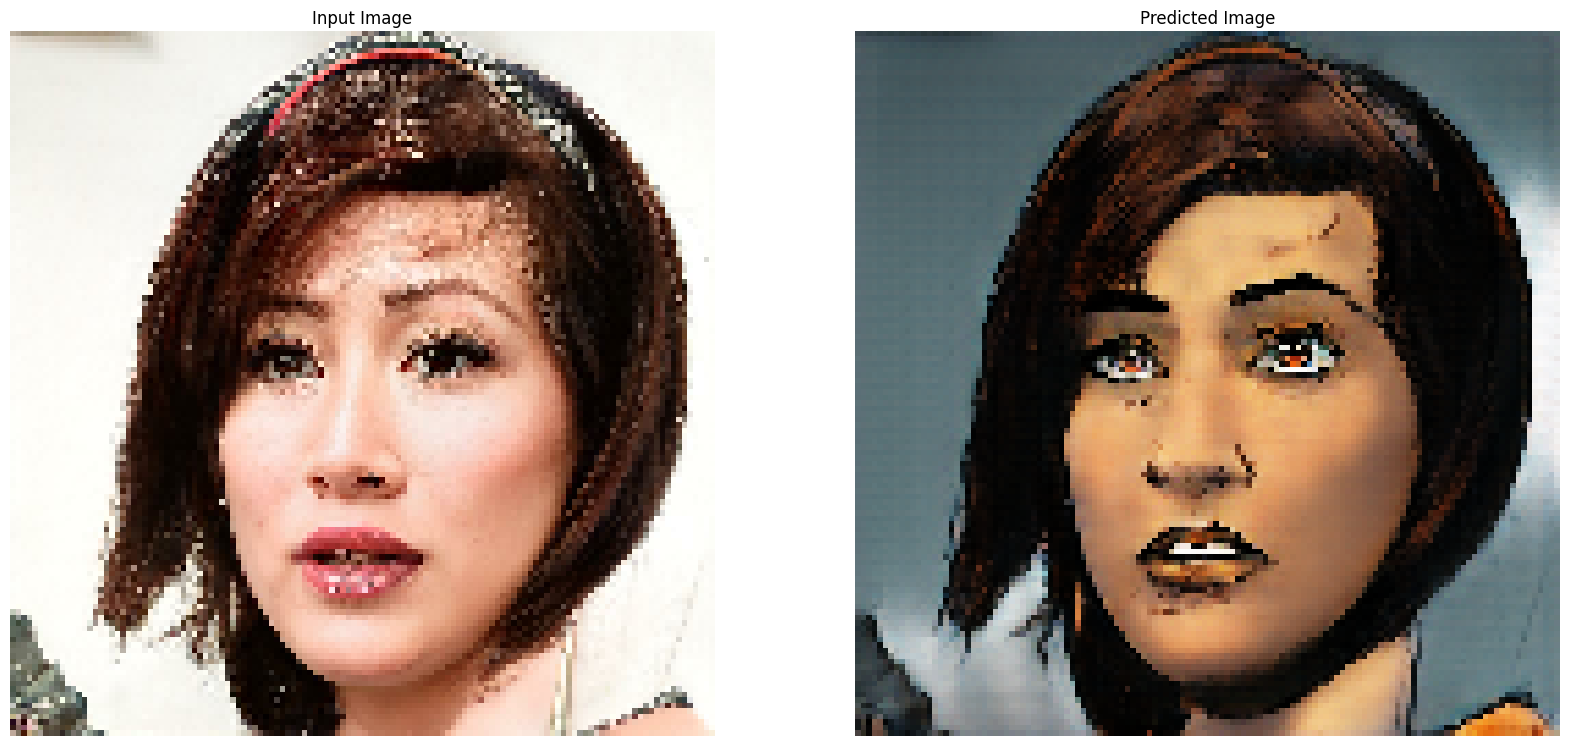

618/618 [==============================] - 61s 98ms/step - face_gen_loss: 3.2687 - anime_gen_loss: 3.4648 - face_disc_loss: 0.5776 - anime_disc_loss: 0.4901
Epoch 34/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.2689 - anime_gen_loss: 3.5542 - face_disc_loss: 0.5793 - anime_disc_loss: 0.4866
Epoch 35/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.2741 - anime_gen_loss: 3.6110 - face_disc_loss: 0.5757 - anime_disc_loss: 0.4796
Epoch 36/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.2532 - anime_gen_loss: 3.5027 - face_disc_loss: 0.5731 - anime_disc_loss: 0.5062WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.2536 - anime_gen_loss: 3.5023 - face_disc_loss: 0.5731 - anime_disc_loss: 0.5061
Epoch 37/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.3289 - anime_gen_loss: 3.6382 - face_disc_loss: 0.5658 - anime_disc_loss: 0.4724

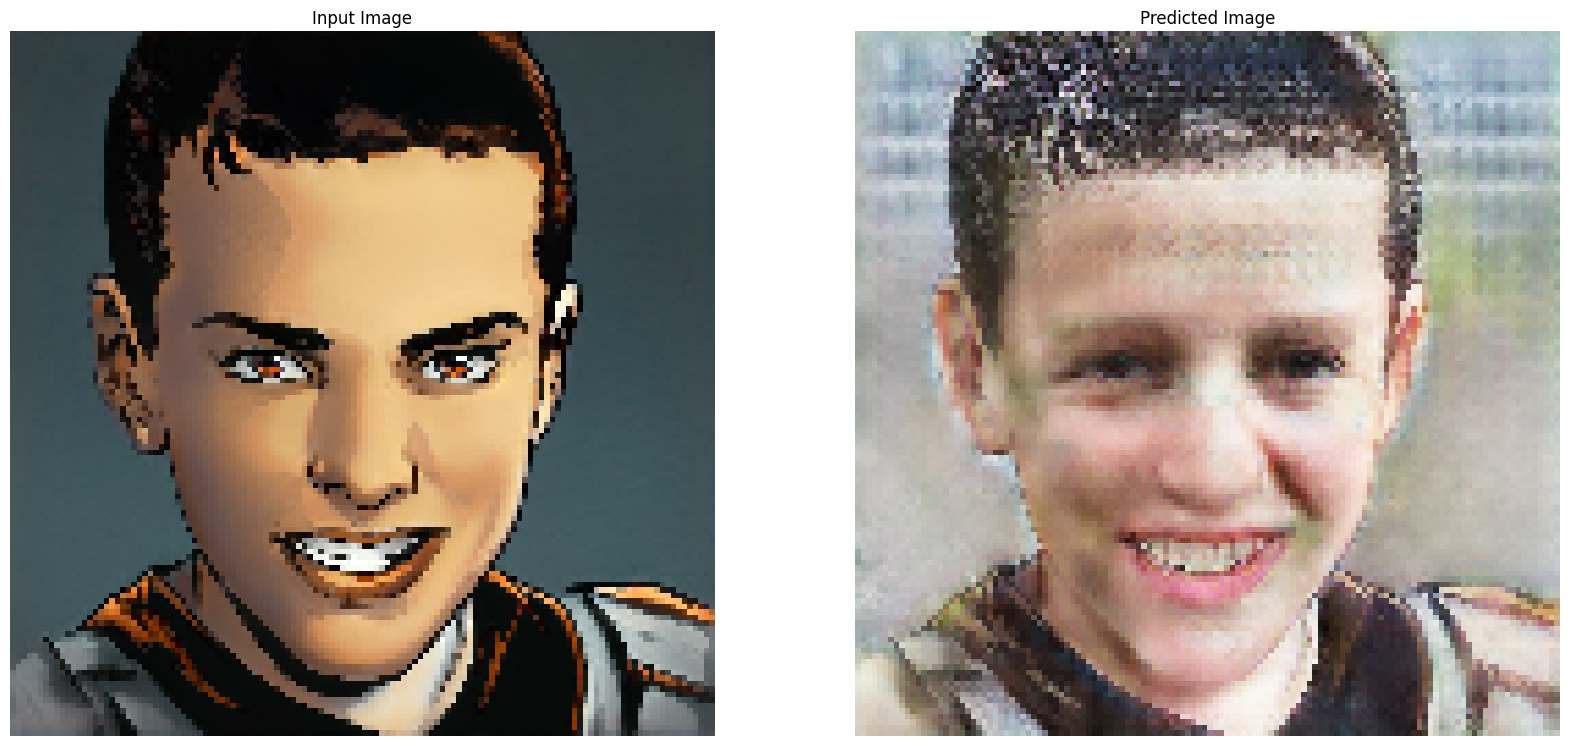

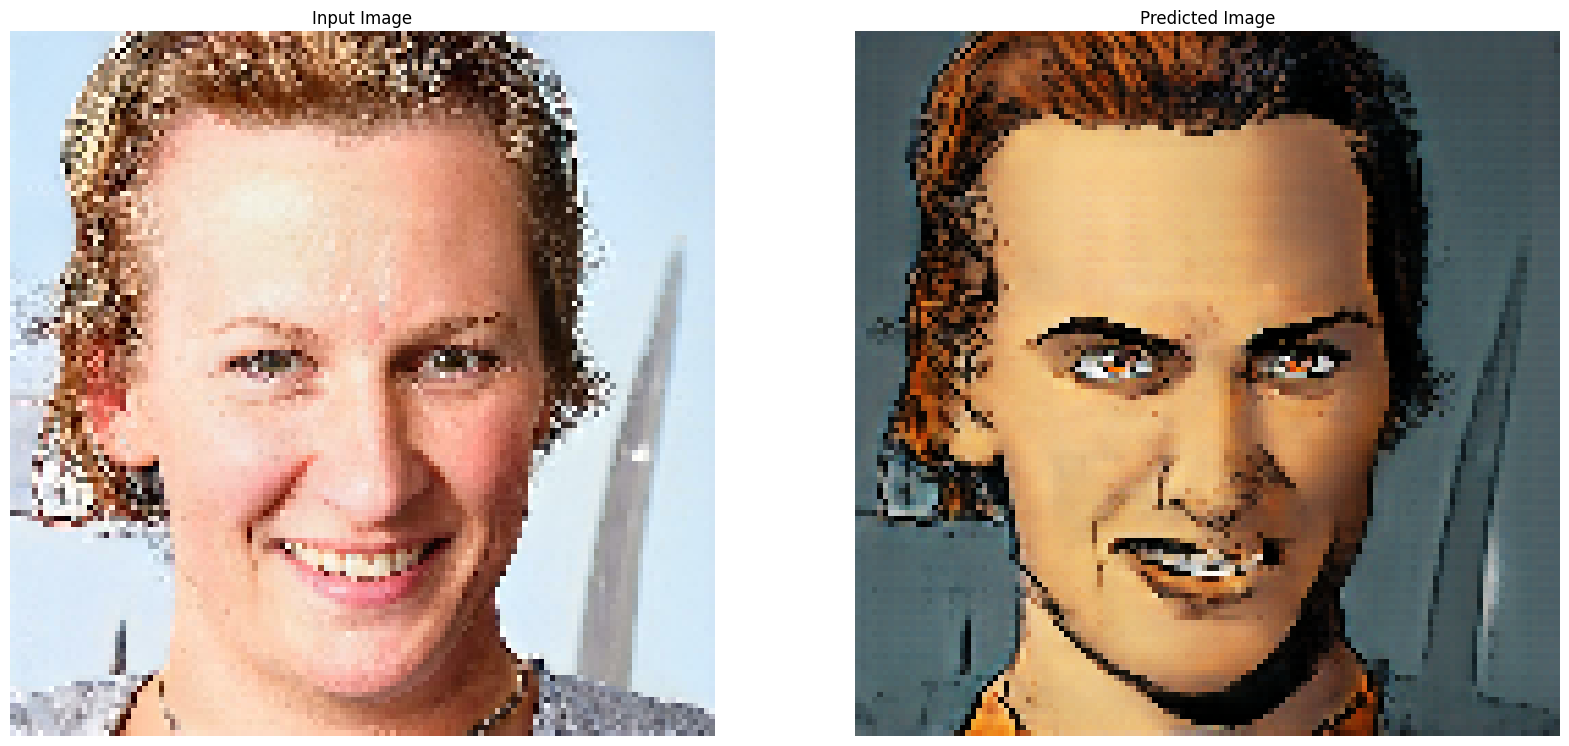

618/618 [==============================] - 61s 98ms/step - face_gen_loss: 3.3286 - anime_gen_loss: 3.6370 - face_disc_loss: 0.5659 - anime_disc_loss: 0.4725
Epoch 38/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.2352 - anime_gen_loss: 3.5315 - face_disc_loss: 0.5818 - anime_disc_loss: 0.5244
Epoch 39/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.2191 - anime_gen_loss: 3.5055 - face_disc_loss: 0.5756 - anime_disc_loss: 0.4865
Epoch 40/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.2168 - anime_gen_loss: 3.5443 - face_disc_loss: 0.5815 - anime_disc_loss: 0.4843
Epoch 41/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.1714 - anime_gen_loss: 3.2688 - face_disc_loss: 0.5767 - anime_disc_loss: 0.5893

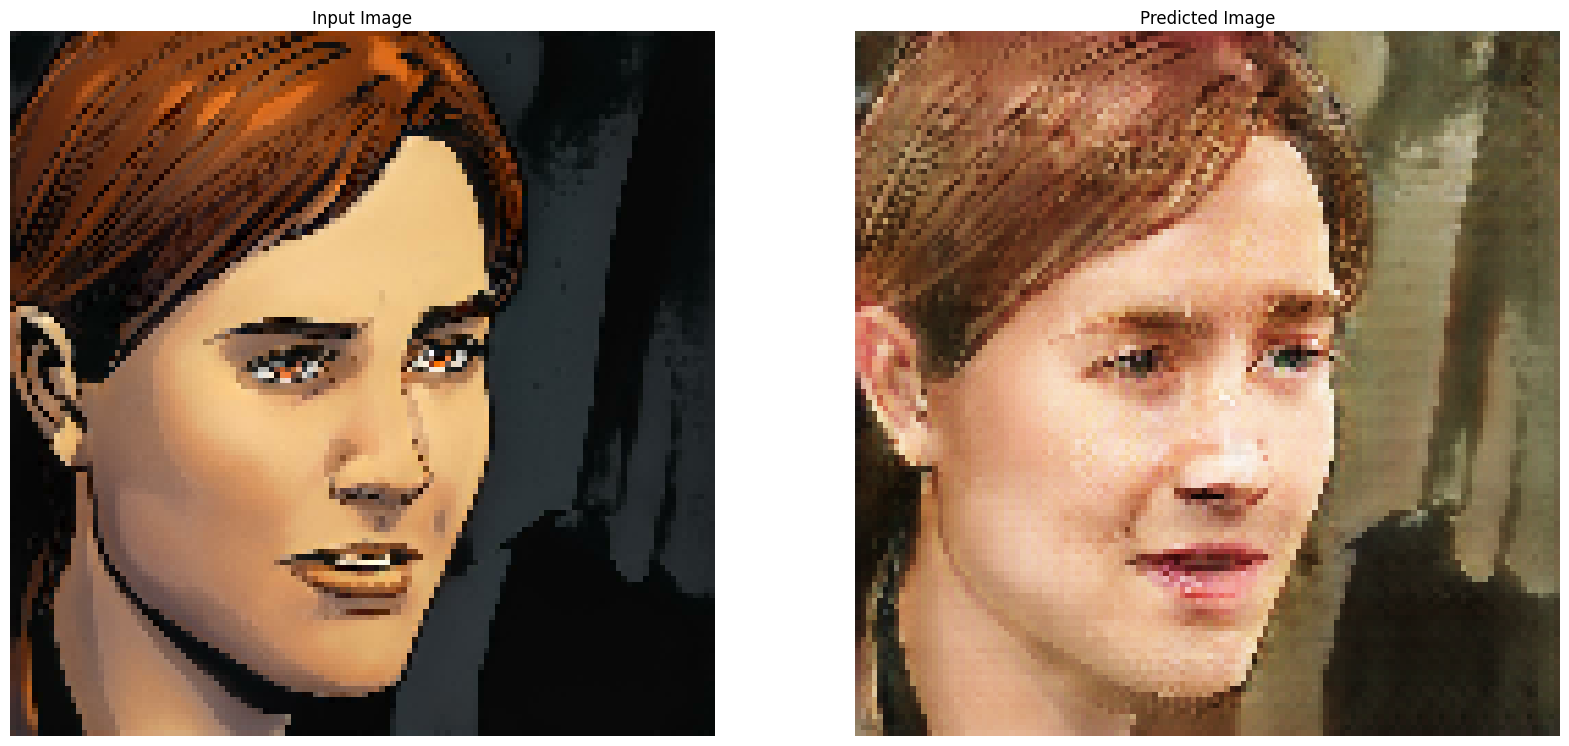

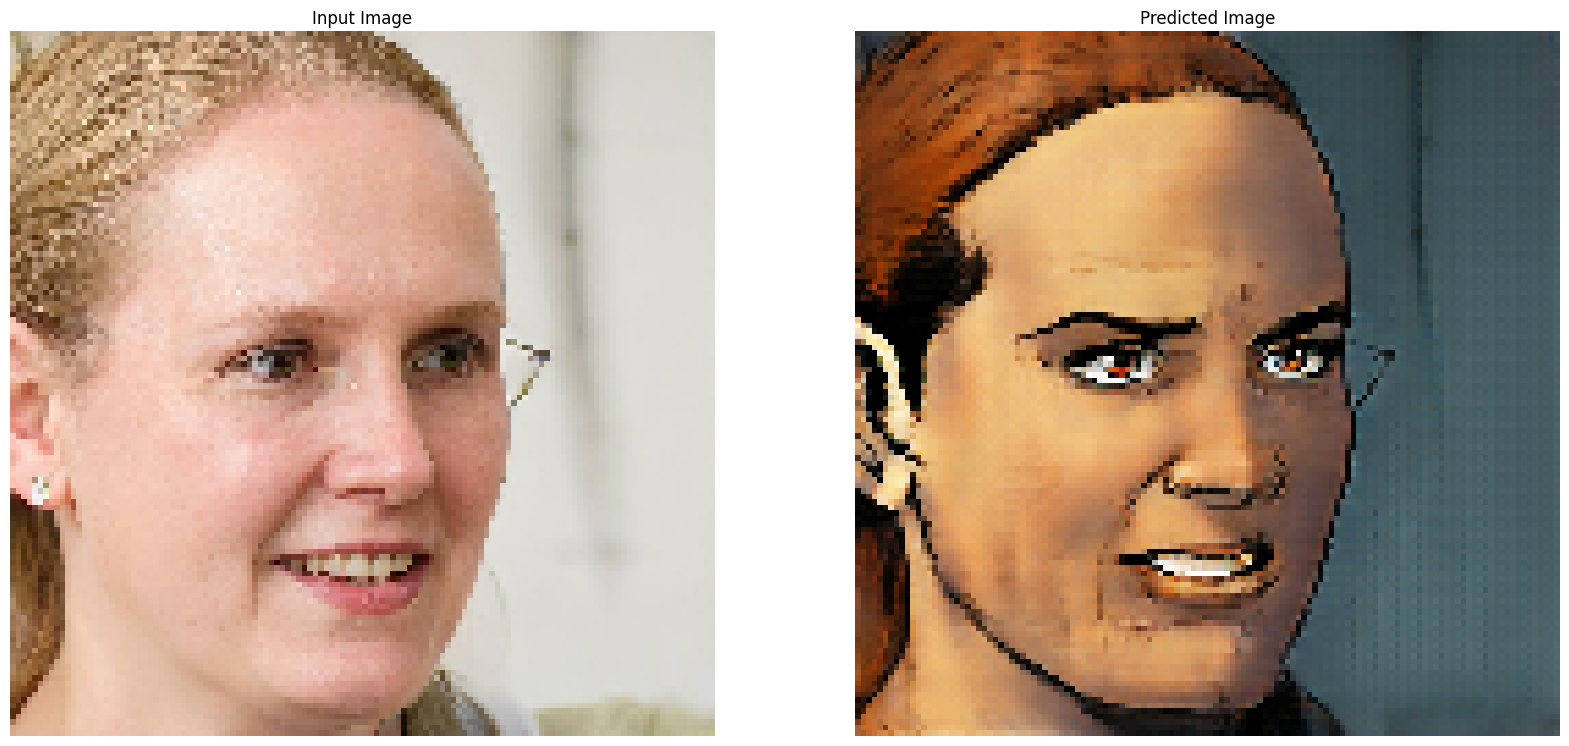

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.1719 - anime_gen_loss: 3.2698 - face_disc_loss: 0.5771 - anime_disc_loss: 0.5889
Epoch 42/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.1762 - anime_gen_loss: 3.4921 - face_disc_loss: 0.5906 - anime_disc_loss: 0.4796
Epoch 43/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.2359 - anime_gen_loss: 3.5109 - face_disc_loss: 0.5672 - anime_disc_loss: 0.5181
Epoch 44/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.2222 - anime_gen_loss: 3.5081 - face_disc_loss: 0.5658 - anime_disc_loss: 0.4789
Epoch 45/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.2027 - anime_gen_loss: 3.6347 - face_disc_loss: 0.5751 - anime_disc_loss: 0.4733

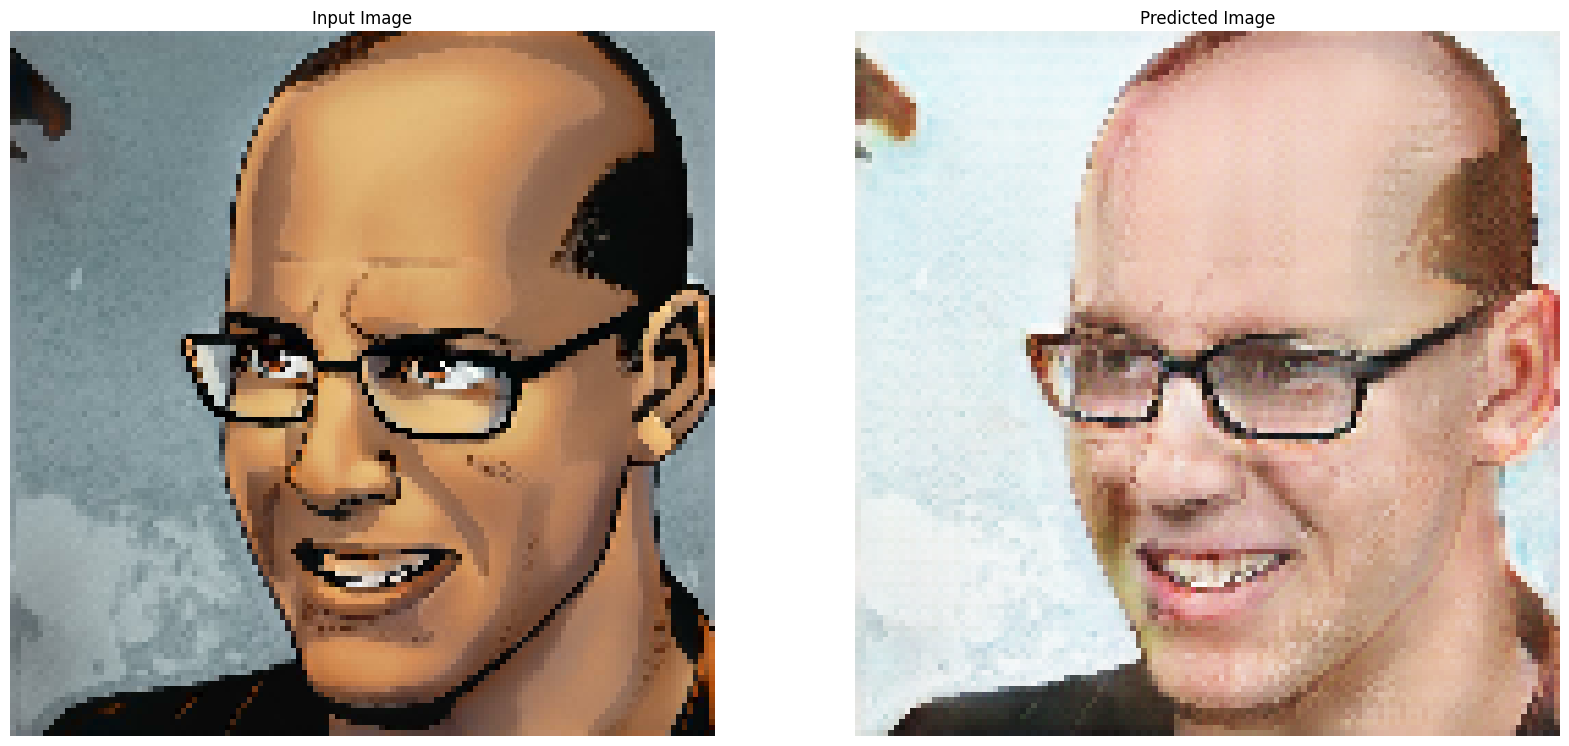

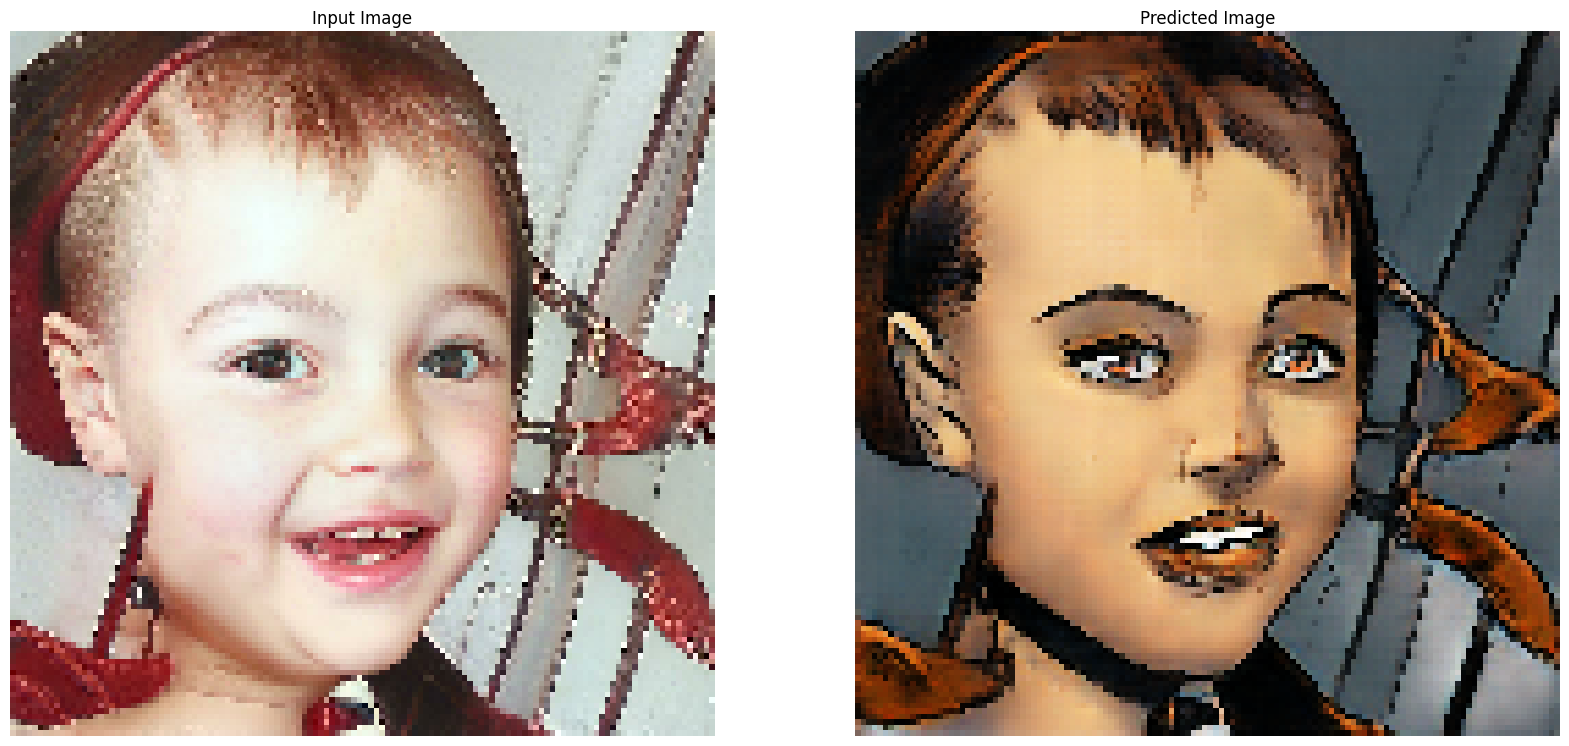

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.2028 - anime_gen_loss: 3.6363 - face_disc_loss: 0.5749 - anime_disc_loss: 0.4732
Epoch 46/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.2449 - anime_gen_loss: 3.5997 - face_disc_loss: 0.5740 - anime_disc_loss: 0.4842WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.2448 - anime_gen_loss: 3.5992 - face_disc_loss: 0.5738 - anime_disc_loss: 0.4841
Epoch 47/50
618/618 [==============================] - 59s 96ms/step - face_gen_loss: 3.1949 - anime_gen_loss: 3.5333 - face_disc_loss: 0.5753 - anime_disc_loss: 0.4823
Epoch 48/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.1787 - anime_gen_loss: 3.5511 - face_disc_loss: 0.5770 - anime_disc_loss: 0.4792
Epoch 49/50
618/618 [==============================] - ETA: 0s - face_gen_loss: 3.1425 - anime_gen_loss: 3.3366 - face_disc_loss: 0.5847 - anime_disc_loss: 0.5631

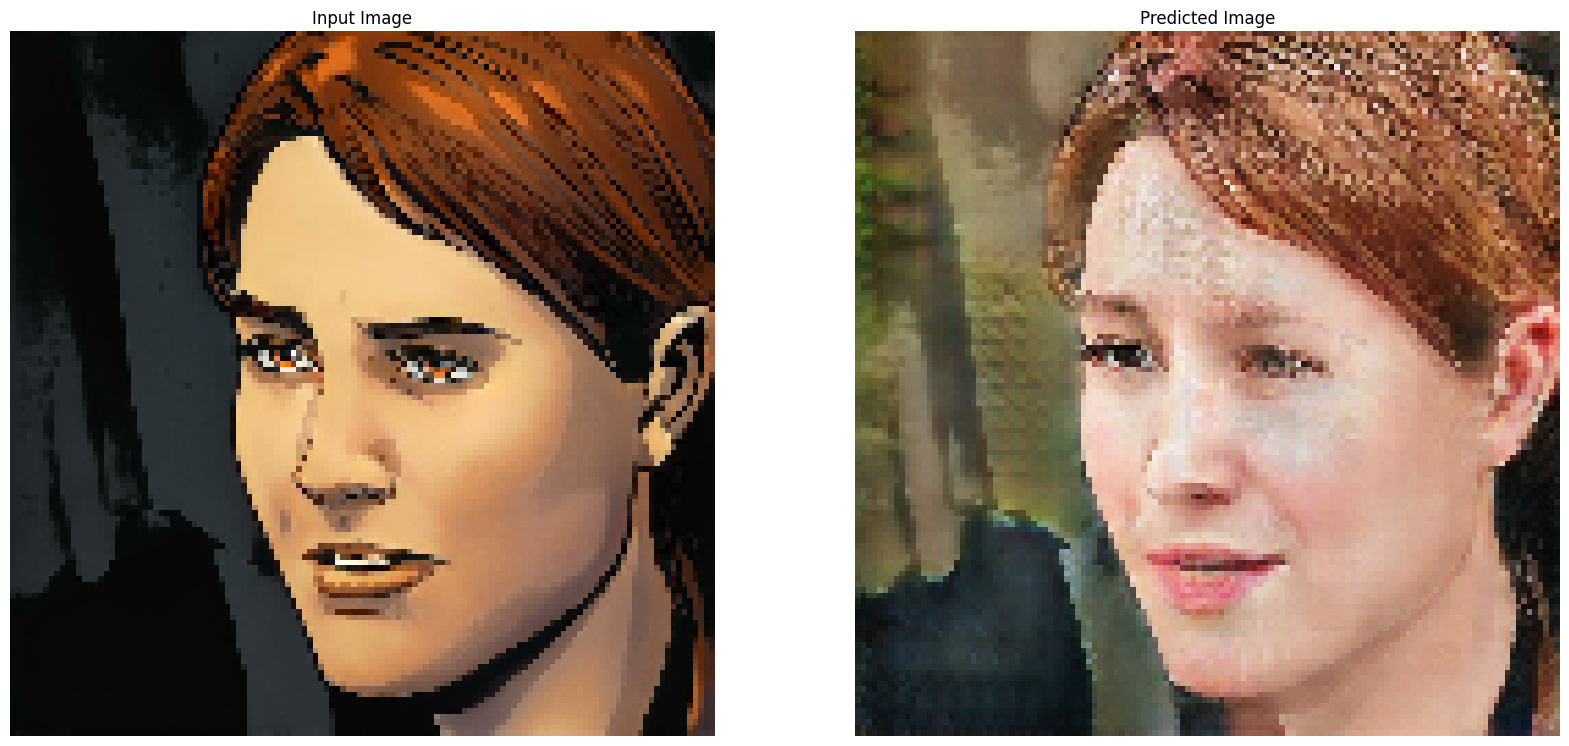

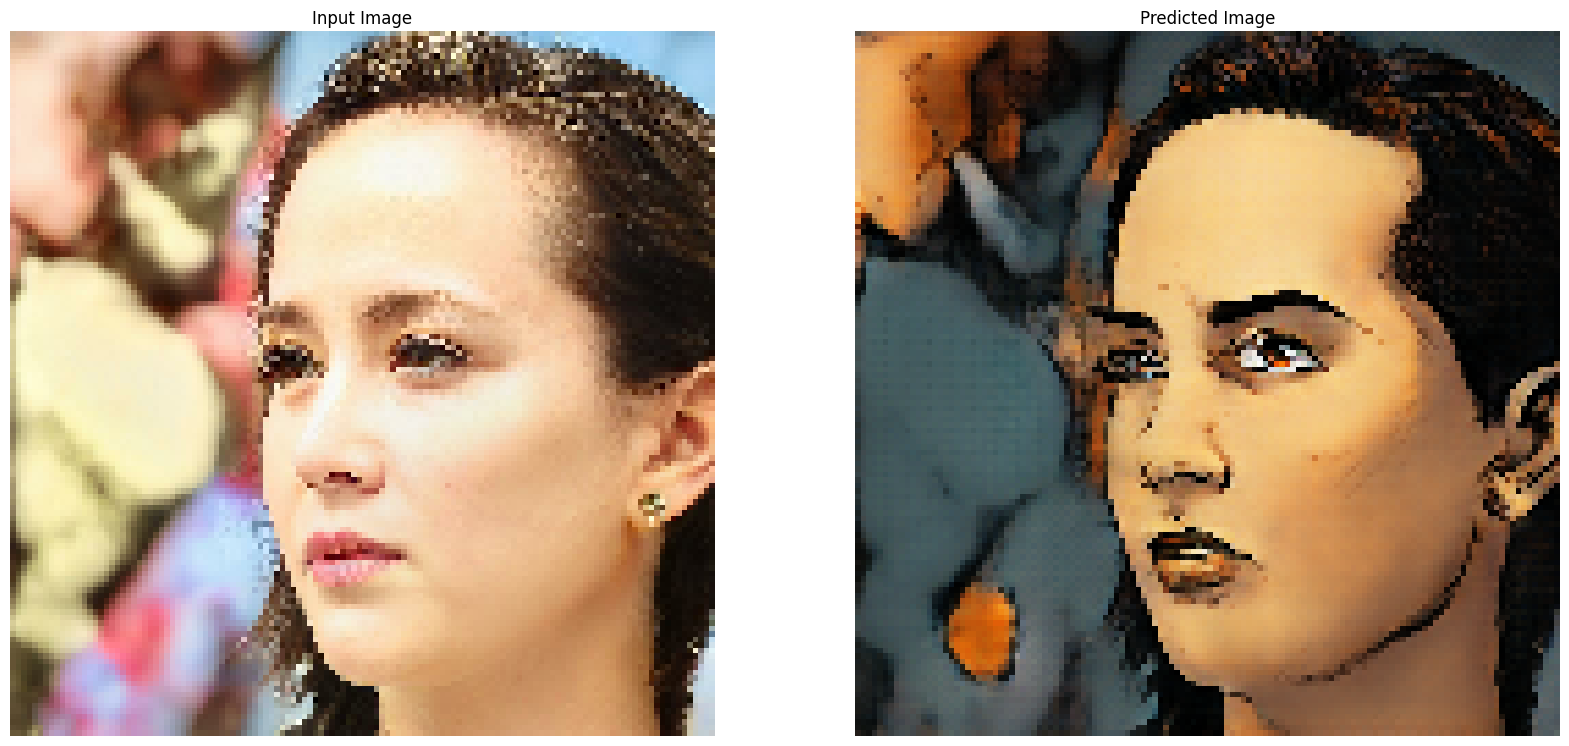

618/618 [==============================] - 61s 99ms/step - face_gen_loss: 3.1435 - anime_gen_loss: 3.3376 - face_disc_loss: 0.5844 - anime_disc_loss: 0.5628
Epoch 50/50
618/618 [==============================] - 59s 95ms/step - face_gen_loss: 3.1869 - anime_gen_loss: 3.4928 - face_disc_loss: 0.5756 - anime_disc_loss: 0.4726


In [19]:
history = cycle_gan_model.fit(
        train_ds,
        epochs=50,verbose=True,callbacks=[GANMonitor(save_every_epoch=5,watch_every_epoch=4)],steps_per_epoch=STEP,initial_epoch=0
    )